In [53]:
from LogErrLoader import LoadDNDSLogErr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
from scipy.ndimage import uniform_filter1d
import scienceplots
from pprint import pprint
from collections import defaultdict
from mg_names import parse_dnds_pmgs_name

plt.style.use(["science"])
font = {"size": 12}

matplotlib.rc("font", **font)
lwc = 0.5
msc = 5
markEvery = 120
markerList = (
    ".",
    "s",
    "o",
    "v",
    "^",
    "<",
    ">",
    "8",
    "p",
    "*",
    "h",
    "H",
    "D",
    "d",
    "P",
    "X",
)
format = "svg"

prefix_order = {"lu": 0, "il": 1, "gm": 2}

base = "NACA0012_H2-MGtest_3_VRes_AOA05.dir"
out_name = "pics/0012_MG_VRes_AOA05"
# base = "NACA0012_H2-MGtest_3_VRes_AOA15.dir"
# out_name = "pics/0012_MG_VRes_AOA15"
base = "CylinderInvisHalfA-MGtest_1_VRes.dir"
out_name = "pics/cylinderHalf_MG_VRes"

file_prefix = "x1-"
# file_prefix = "x0-"
# file_prefix = ""
omit_parsed_select = True
M1s = [0, 1, 2, 4, 8]
M0s = [0, 1, 2, 4, 8]
M0s = [0, 1, 2, 4, 8, 16]  # for enlarged table of M1 M2 tests
series = ["all", "ilu", "lusgs", "gmres5x1ilu", "gmres5x1lusgs"]
# series = ["all"]
#! for 15 AOA
tRanges = np.array([250, 250, 700, 250, 700]) 
nRanges = np.array([2500, 2500, 7000, 2500, 4000])
#! for  5 AOA
tRanges = np.array([250, 100, 700, 100, 200])
nRanges = np.array([10000, 2500, 7000, 2500, 2500])

detectRes = 1e-6

tRanges = [None, None, None, None, None]
nRanges = [None, None, None, None, None]

precise_selection = set()
# precise_selection = [
#     "lusgs",
#     "ilu",
#     "gmres5x1lusgs",
#     "gmres5x1ilu",
# ]
precise_selection = set([s + "_.log" for s in precise_selection])


def windowed_std(arr, window_size: int):
    mean = uniform_filter1d(arr, size=window_size, mode="reflect")
    mean_sq = uniform_filter1d(arr**2, size=window_size, mode="reflect")
    std = np.sqrt(mean_sq - mean**2)
    return std[0:-window_size]


logs_AOA15 = os.listdir(base)
logs_AOA15 = list(
    filter(
        lambda s: s.endswith(".log")
        and (s.startswith(file_prefix) if file_prefix else not s.startswith("x")),
        logs_AOA15,
    )
)
logs_AOA15 = [s[len(file_prefix) :] for s in logs_AOA15]
if precise_selection:
    logs_AOA15 = list(filter(lambda s: s in precise_selection, logs_AOA15))


def parse_selector(s: str):
    if omit_parsed_select:
        return True
    #! filter out 8 smoothers
    info = parse_dnds_pmgs_name(s)
    if len(info) >= 2 and info[1][0] >= 8:
        return False
    if len(info) >= 3 and info[2][0] >= 8:
        return False
    return True


logs_AOA15 = list(filter(parse_selector, logs_AOA15))


logs_AOA15.sort(key=lambda s: (prefix_order[s[0:2]], len(s), s))


pprint(logs_AOA15)
data_AOA15 = []
data_AOA15_resMaxes = {}
for log in logs_AOA15:
    m = re.match(r"([\w-]+)_.log", log)
    name = m.group(1)
    data = LoadDNDSLogErr(os.path.join(base, file_prefix + log))
    data_AOA15.append((data, name))
    for key in data:
        max_v = np.array(data[key]).max()
        if key.startswith("res"):
            data_AOA15_resMaxes[key] = (
                max(data_AOA15_resMaxes[key], max_v)
                if key in data_AOA15_resMaxes.keys()
                else max_v
            )

label_map = {
    "ilu": "ILU",
    "gmres5x1": "GMRES+",
    "lusgs": "LUSGS",
}


def name_mapper(name: str):
    for a, b in label_map.items():
        name = name.replace(a, b)
    return name


def plotOne(data, label, plotIndex=0, xAxis="tWall", yAxis="res0", std=0):
    color_seq = matplotlib.color_sequences["tab10"]
    dataY = np.array(data[yAxis][0:-1])
    dataX = np.array(data[xAxis][0:-1])
    if xAxis == "tWall":
        dataX = dataX - dataX[0] + dataX[1] - dataX[0]
    if std > 0:
        dataY = windowed_std(dataY, std)
        dataX = dataX[0 : len(dataY)]
    if yAxis.startswith("res"):
        dataY /= data_AOA15_resMaxes[yAxis]
    plt.plot(
        dataX,
        dataY,
        label=label,
        lw=lwc,
        marker=markerList[plotIndex % len(markerList)],
        markevery=markEvery,
        markersize=msc,
        markeredgewidth=lwc,
        markerfacecolor="none",
        color=color_seq[plotIndex % len(color_seq)],
    )
    return plotIndex + 1


def plotAfter(xlim, xlabel="t", ylabel="res0", logy=True):
    if logy:
        plt.yscale("log")
    leg = plt.legend(fontsize=9)
    plt.xlim(xlim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(visible=True, which="both", alpha=0.3)

['lusgs_.log',
 'lusgs-2lusgs_.log',
 'lusgs-4lusgs_.log',
 'lusgs-8lusgs_.log',
 'lusgs-16lusgs_.log',
 'lusgs-1lusgs-2lusgs_.log',
 'lusgs-1lusgs-4lusgs_.log',
 'lusgs-1lusgs-8lusgs_.log',
 'lusgs-2lusgs-2lusgs_.log',
 'lusgs-2lusgs-4lusgs_.log',
 'lusgs-2lusgs-8lusgs_.log',
 'lusgs-4lusgs-2lusgs_.log',
 'lusgs-4lusgs-4lusgs_.log',
 'lusgs-4lusgs-8lusgs_.log',
 'lusgs-8lusgs-2lusgs_.log',
 'lusgs-8lusgs-4lusgs_.log',
 'lusgs-8lusgs-8lusgs_.log',
 'lusgs-1lusgs-16lusgs_.log',
 'lusgs-2lusgs-16lusgs_.log',
 'lusgs-4lusgs-16lusgs_.log',
 'lusgs-8lusgs-16lusgs_.log',
 'ilu_.log',
 'ilu-2ilu_.log',
 'ilu-4ilu_.log',
 'ilu-8ilu_.log',
 'ilu-16ilu_.log',
 'ilu-1ilu-2ilu_.log',
 'ilu-1ilu-4ilu_.log',
 'ilu-1ilu-8ilu_.log',
 'ilu-2ilu-2ilu_.log',
 'ilu-2ilu-4ilu_.log',
 'ilu-2ilu-8ilu_.log',
 'ilu-4ilu-2ilu_.log',
 'ilu-4ilu-4ilu_.log',
 'ilu-4ilu-8ilu_.log',
 'ilu-8ilu-2ilu_.log',
 'ilu-8ilu-4ilu_.log',
 'ilu-8ilu-8ilu_.log',
 'ilu-1ilu-16ilu_.log',
 'ilu-2ilu-16ilu_.log',
 'ilu-4ilu-16ilu_.

In [ ]:
data_reach = defaultdict(list)
for i, (data, name) in enumerate(data_AOA15):
    dataRes = np.array(data["res0"][0:-1])
    dataX = np.array(data["tWall"][0:-1])
    dataX = dataX - dataX[0] + dataX[1] - dataX[0]
    dataI = np.array(data["iterAll"][0:-1])
    dataRes = dataRes / data_AOA15_resMaxes["res0"]
    time_reaches = dataX[dataRes <= detectRes]
    I_reaches = dataI[dataRes <= detectRes]
    if time_reaches.size == 0:
        time_reach = float("inf")
        I_reach = float("inf")
    else:
        time_reach = time_reaches.min()
        I_reach = I_reaches.min()
    info = parse_dnds_pmgs_name(name, 3)
    data_reach[info[0][1]].append(((info[1][0], info[2][0]), (time_reach, I_reach)))
    # print(f"{name_mapper(name)} & {time_reach:.2f} & {I_reach:.0f}")

# 2d table
M1i = {v: i for i, v in enumerate(M1s)}
M0i = {v: i for i, v in enumerate(M0s)}
for main_name, datas in data_reach.items():
    print("\n" + "=" * 64)
    print(main_name)
    dataSheet = np.zeros((len(M1s), len(M0s)) + (2,), dtype=np.float64) - 1
    for (m1, m0), data in datas:
        if m1 in M1i and m0 in M0i:
            dataSheet[M1i[m1], M0i[m0]] = np.array(data)

    def print_sheet(i_data, fmt=".2f"):
        print(" " + "".join([f" & $M_0={v}$" for v in M0s]) + "\\\\")
        for i, m1 in enumerate(M1s):
            words = []
            for j, m0 in enumerate(M0s):
                val = dataSheet[i, j, i_data]
                words.append("-" if val < 0 else f"{{val:{fmt}}}".format(val=val))
            print("\\hline")
            print(f"$M_1={m1}$ & " + " & ".join(words) + "\\\\")

    print("\ntime:")
    print_sheet(0)
    print("\niterations:")
    print_sheet(1, ".0f")


lusgs


KeyError: 16

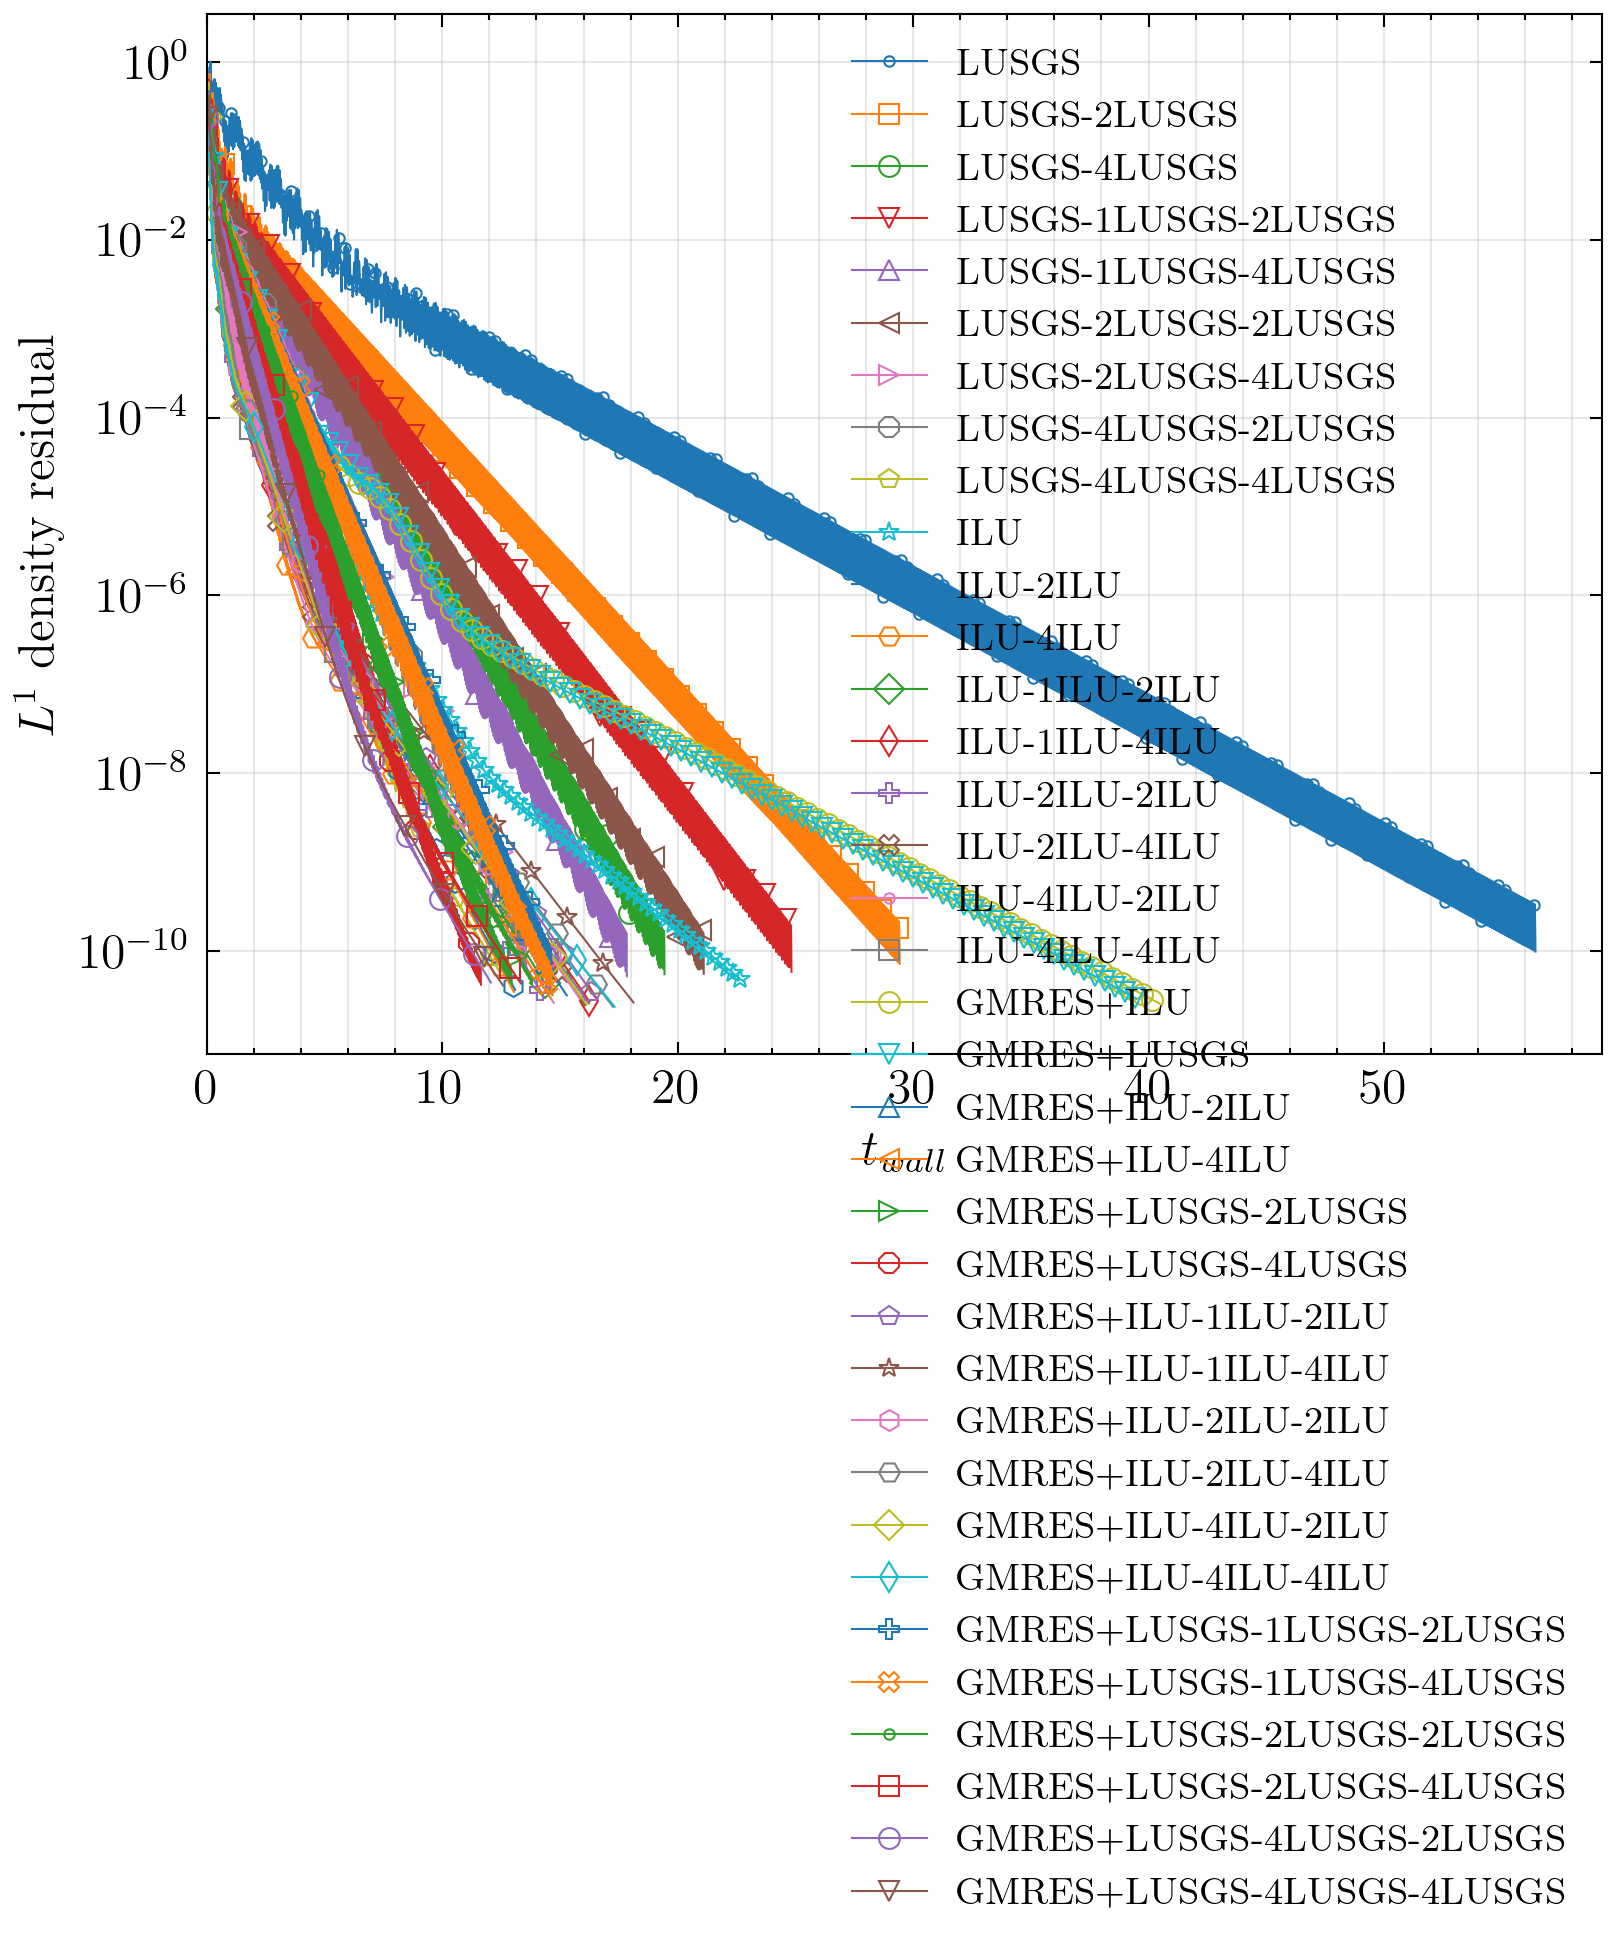

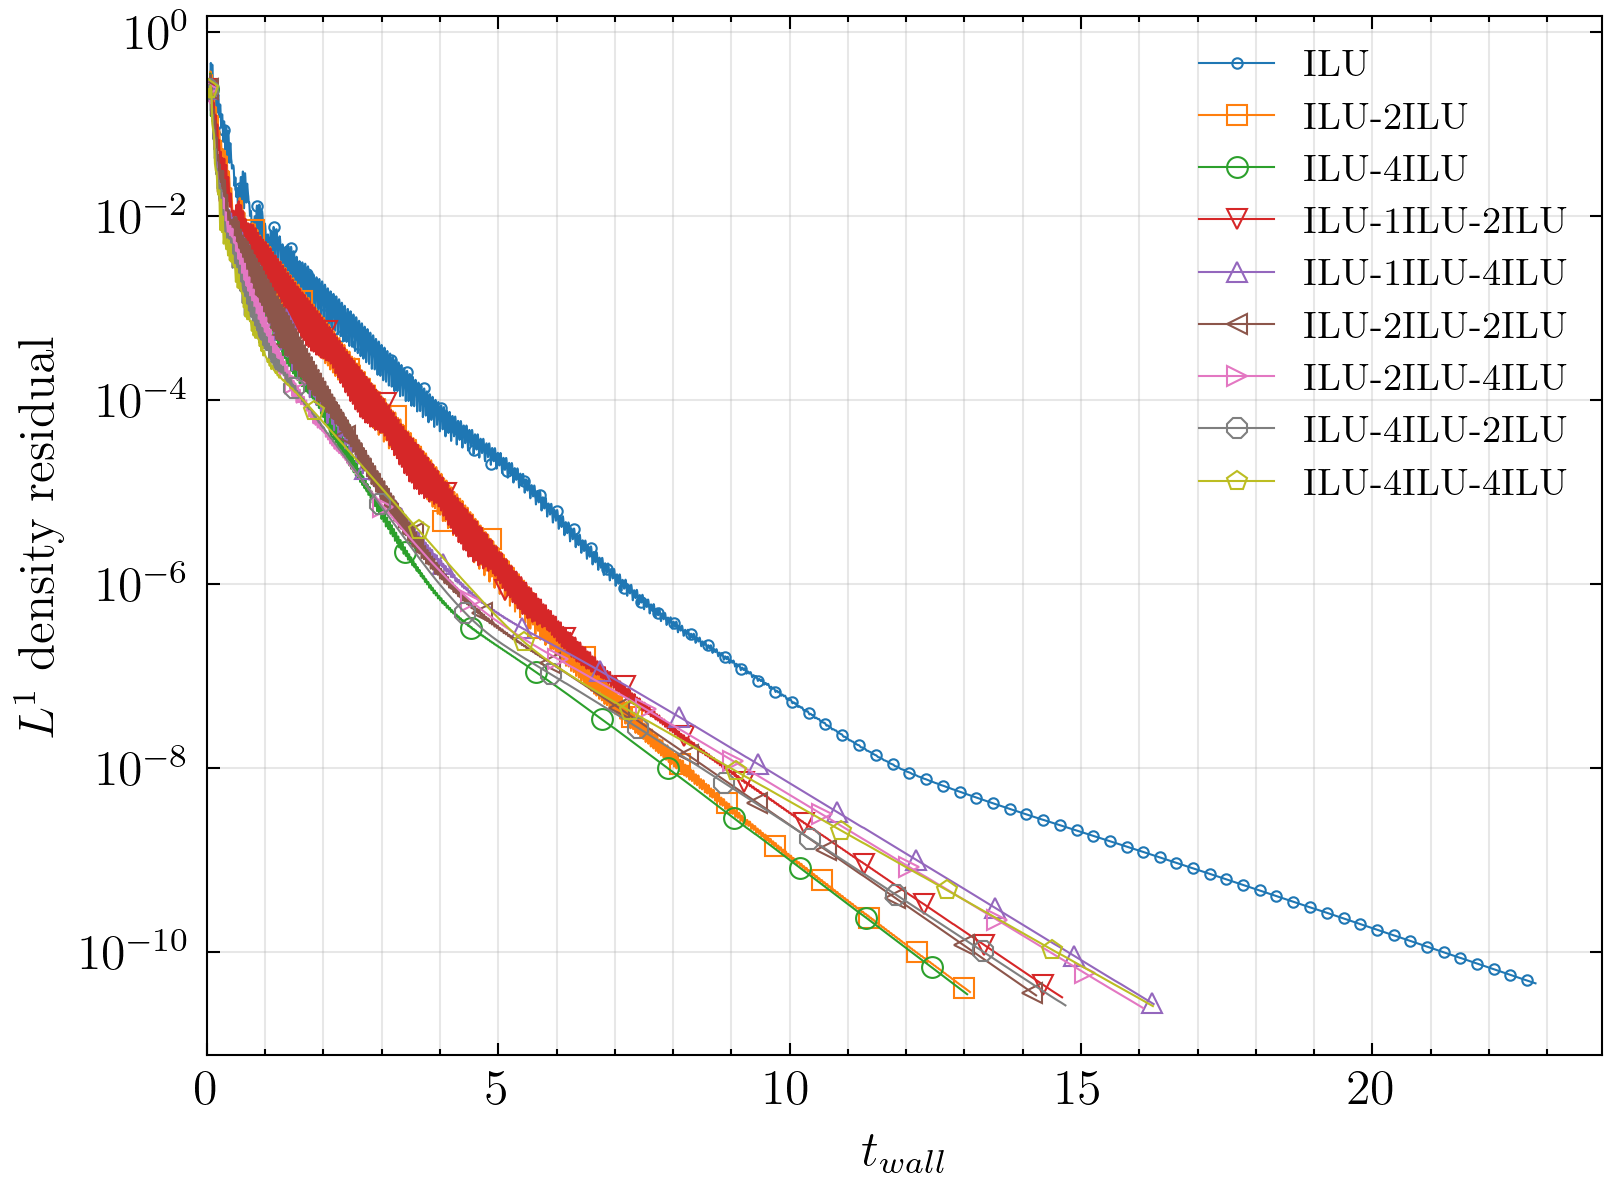

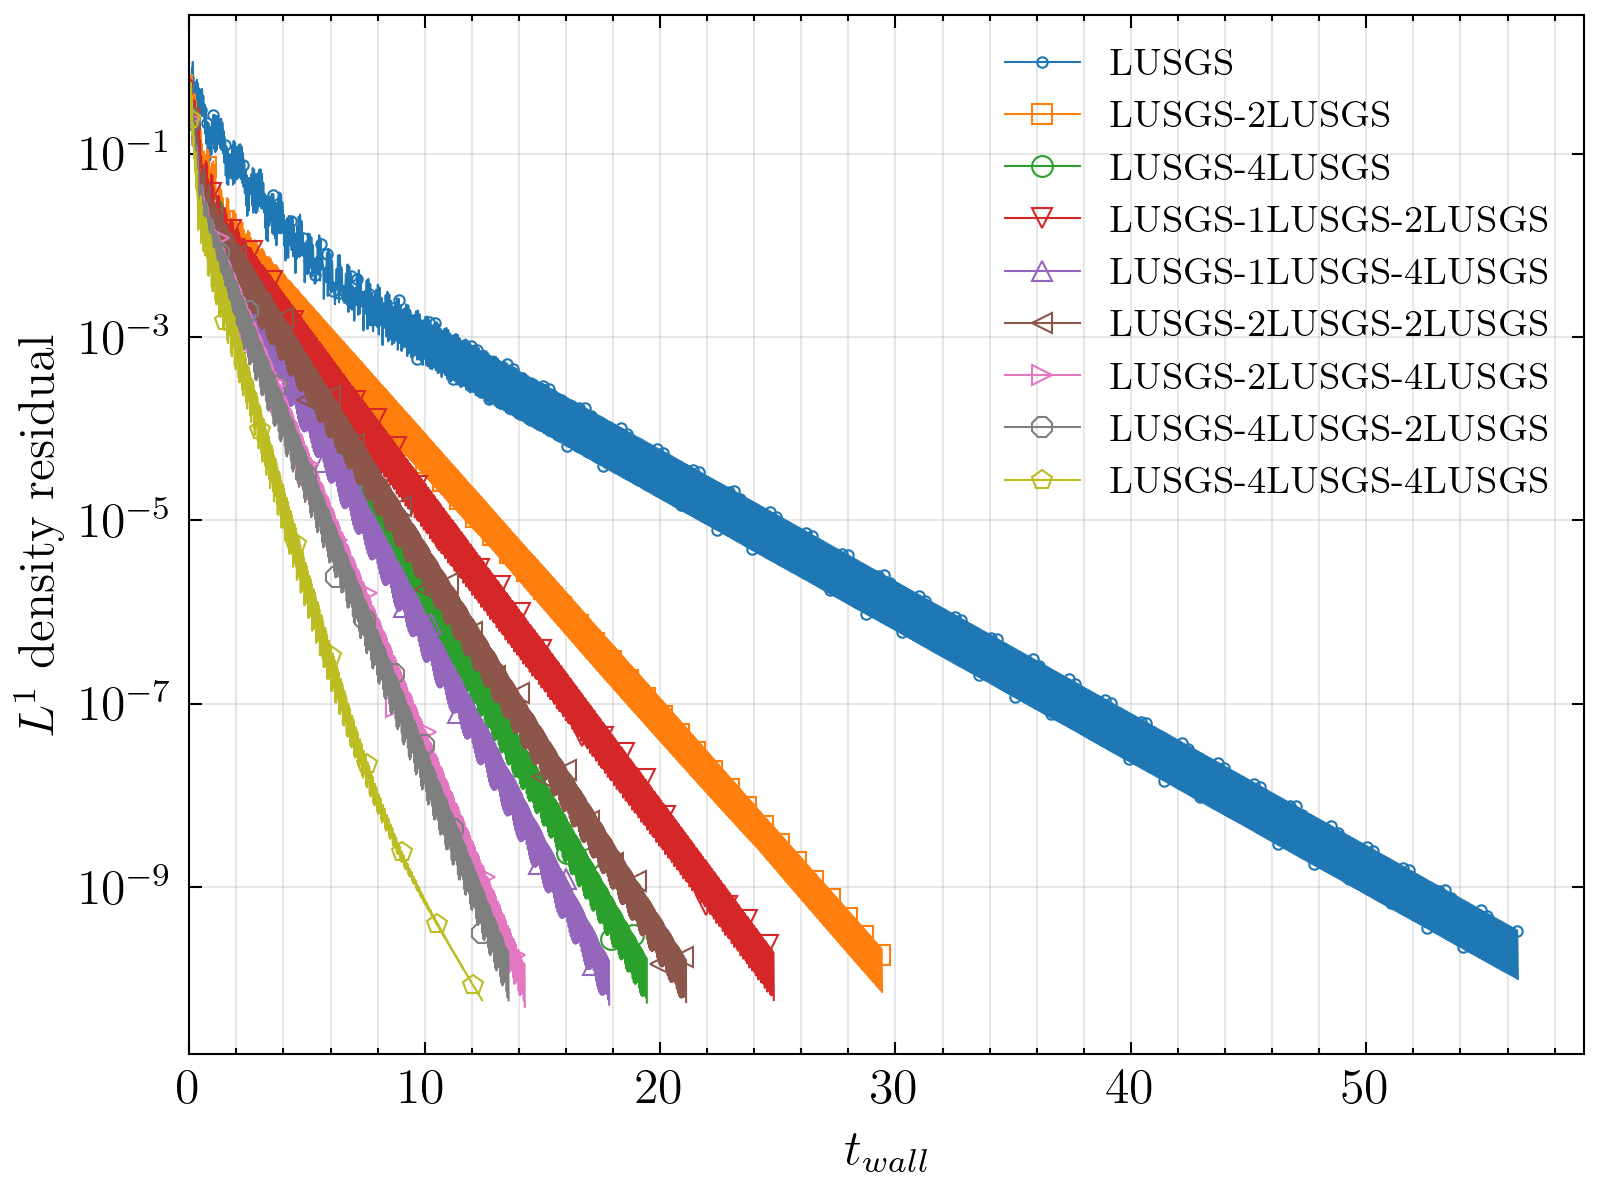

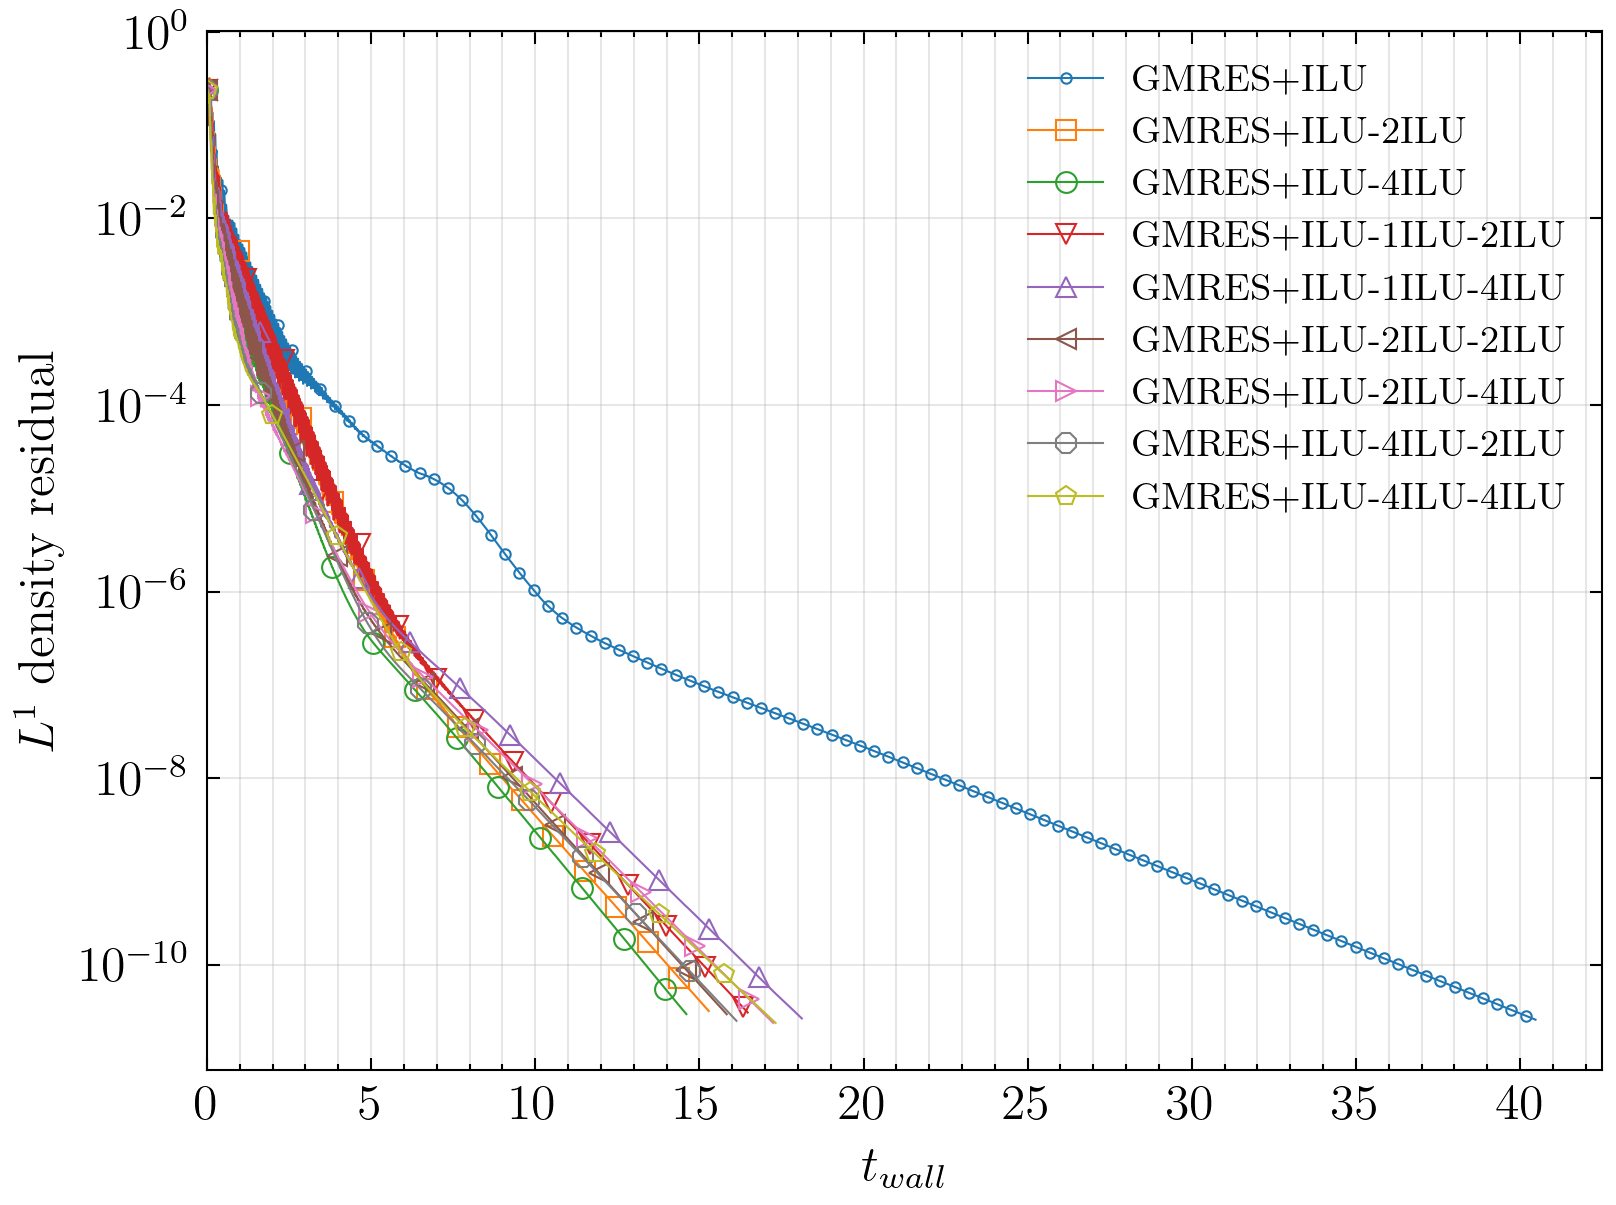

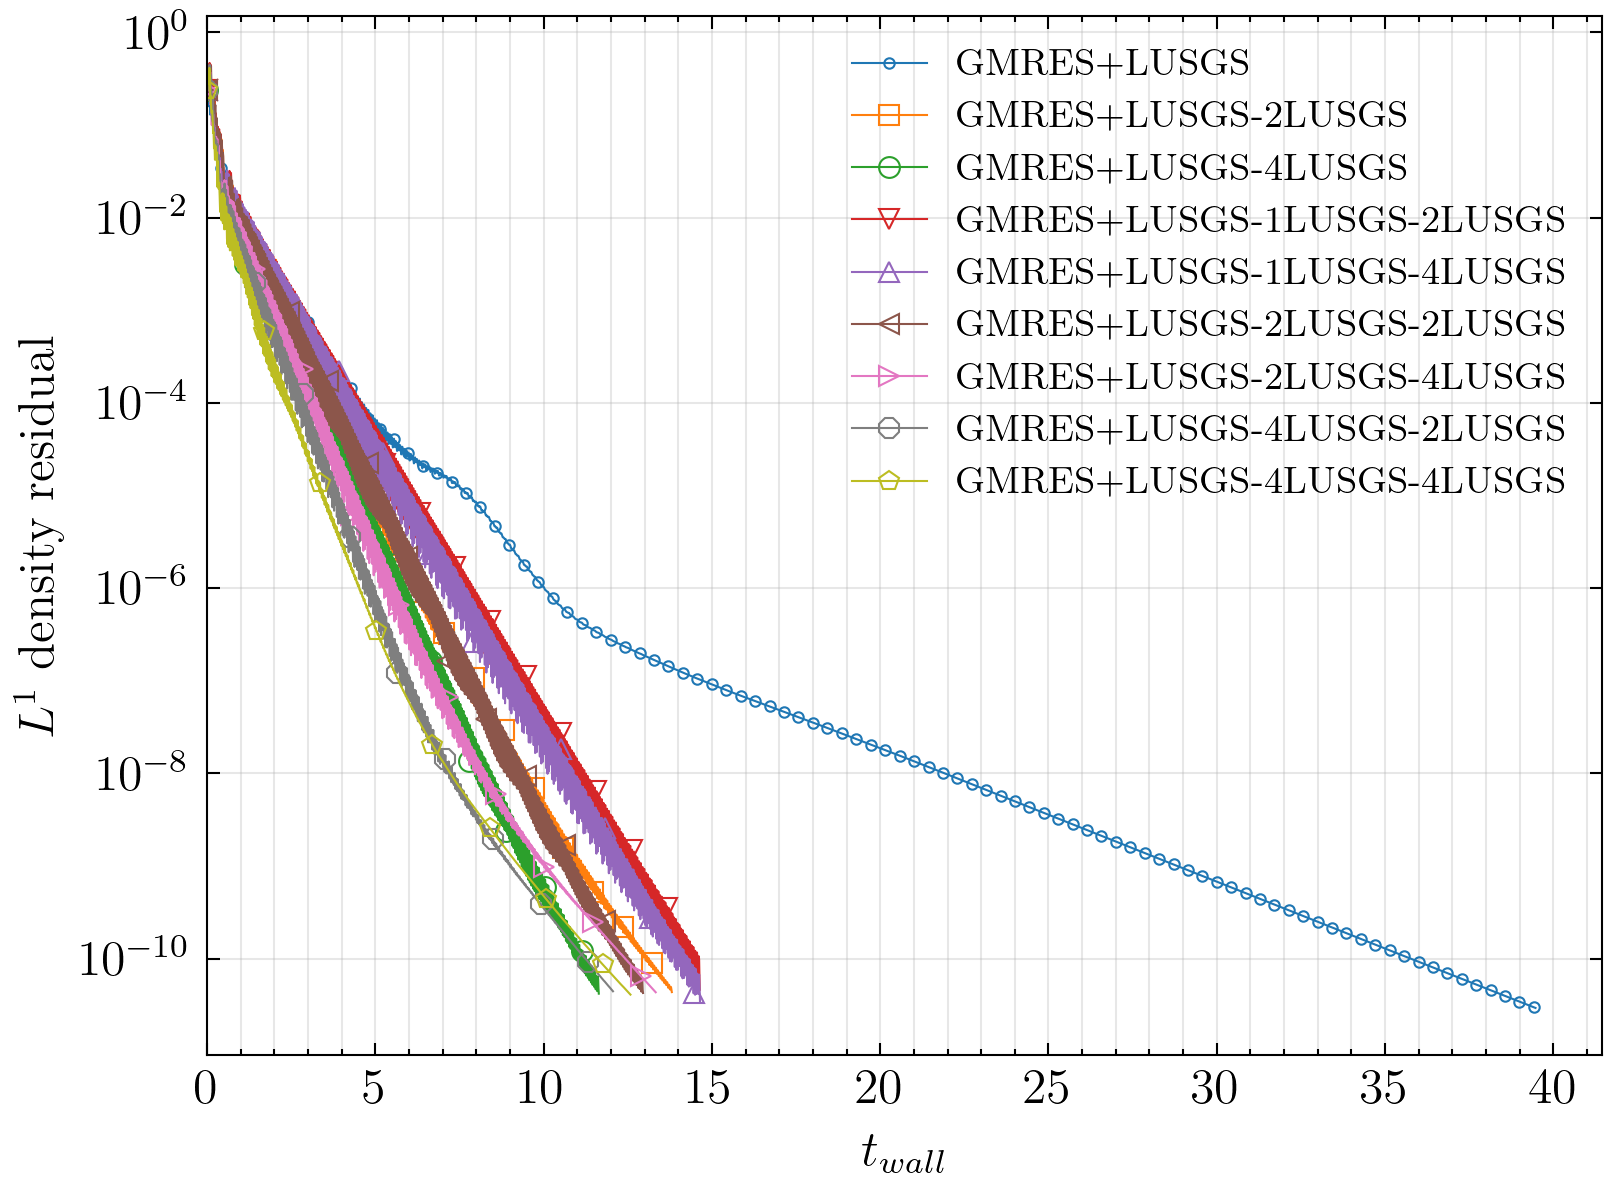

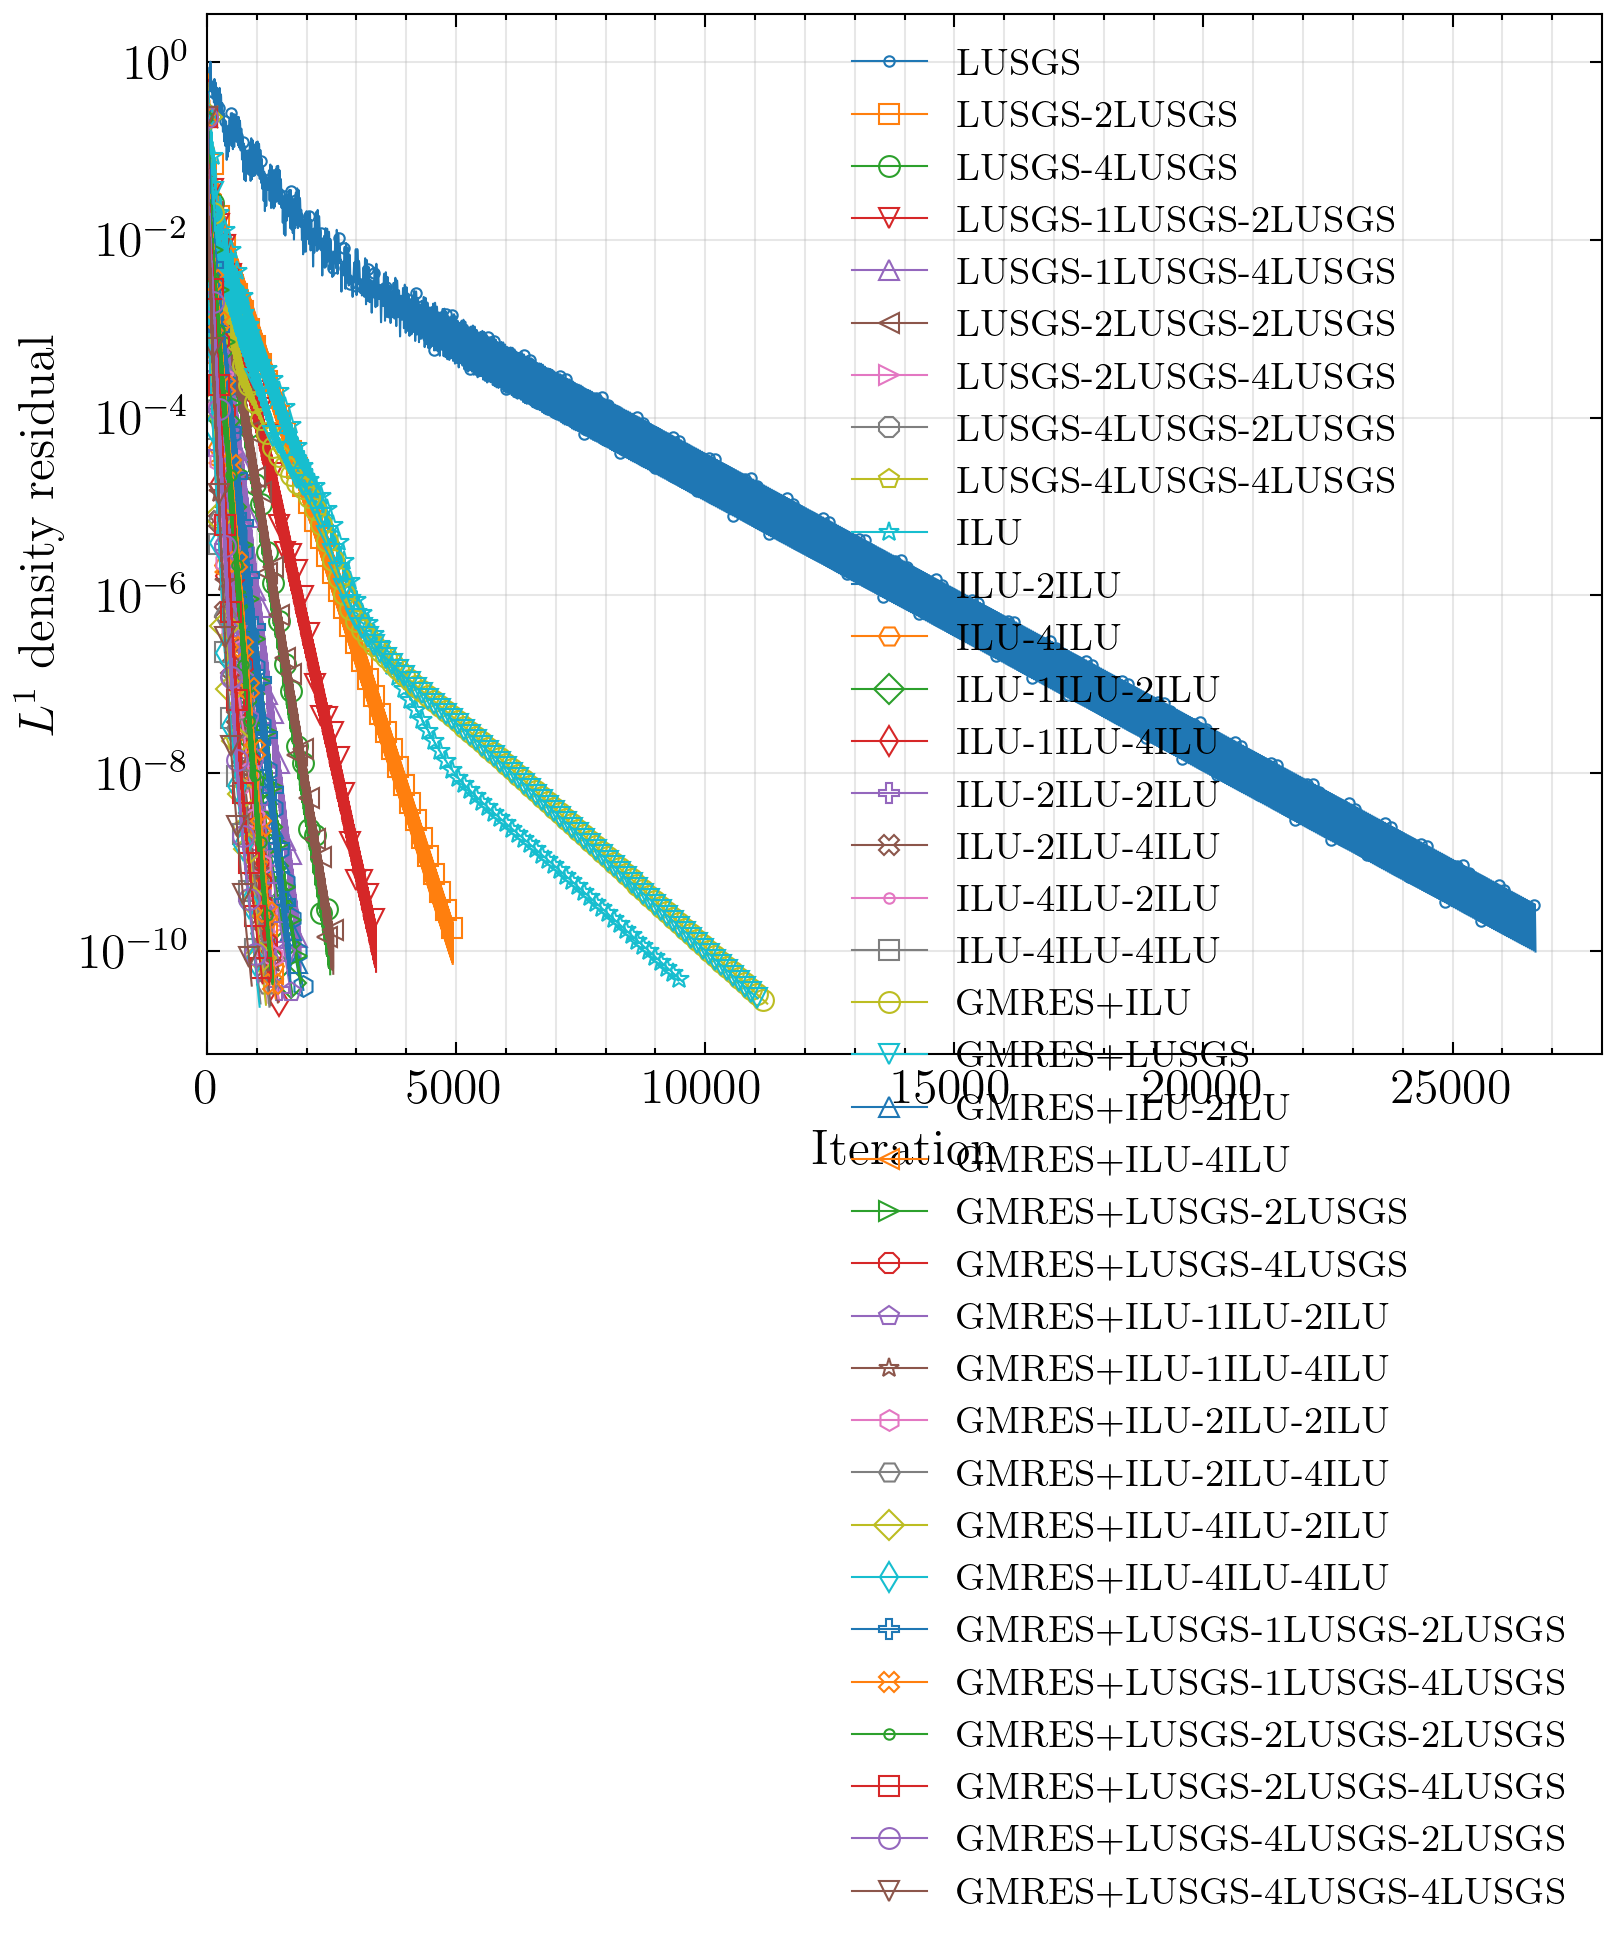

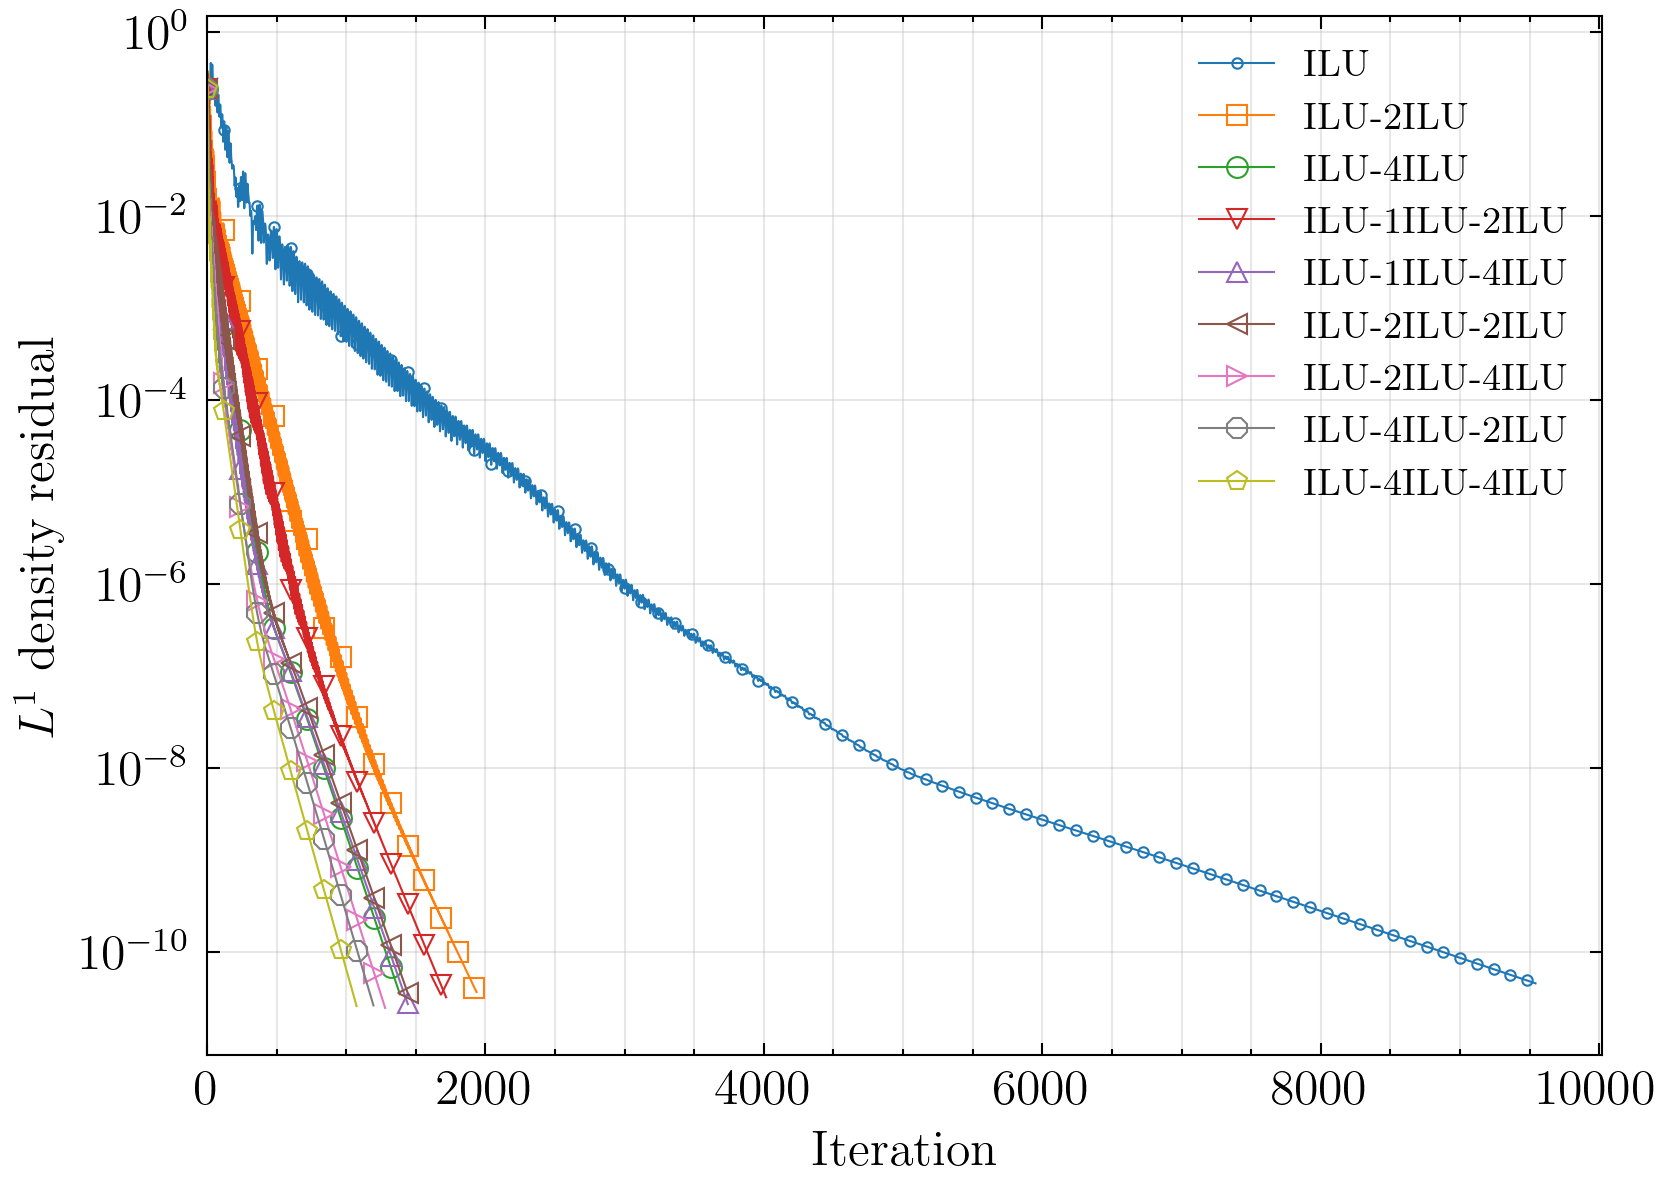

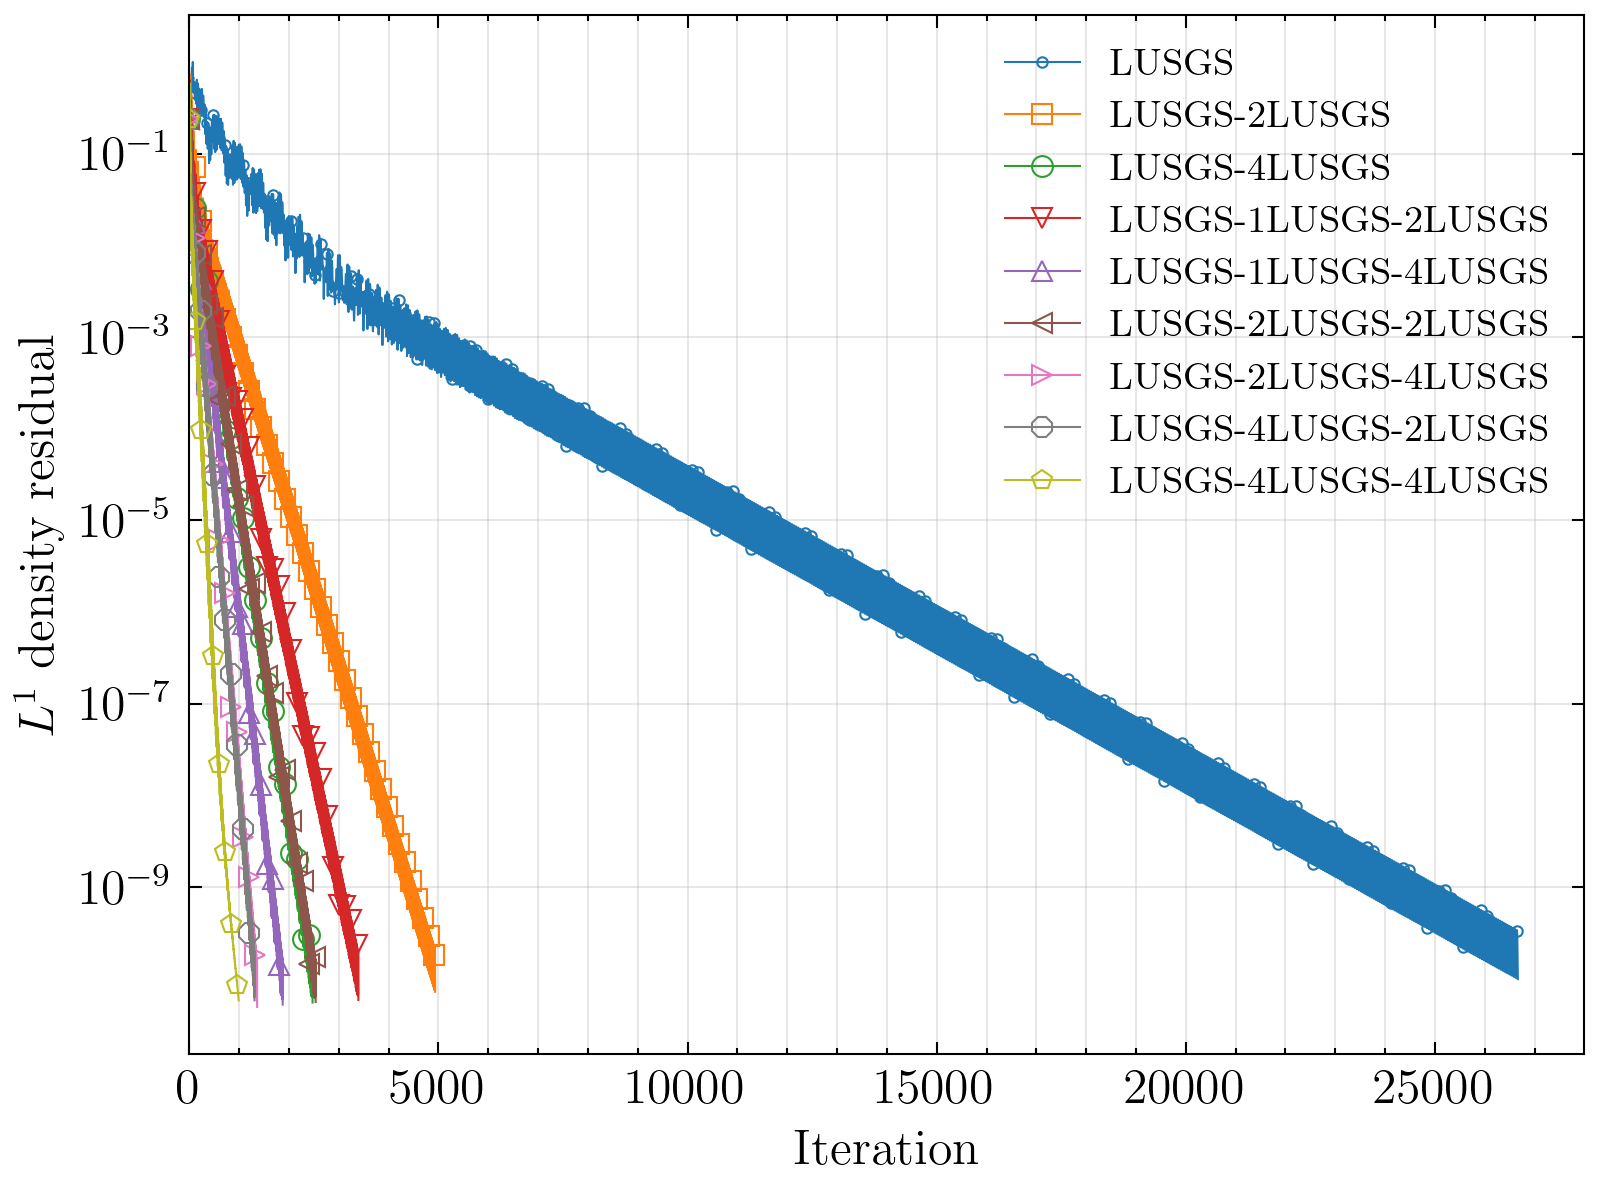

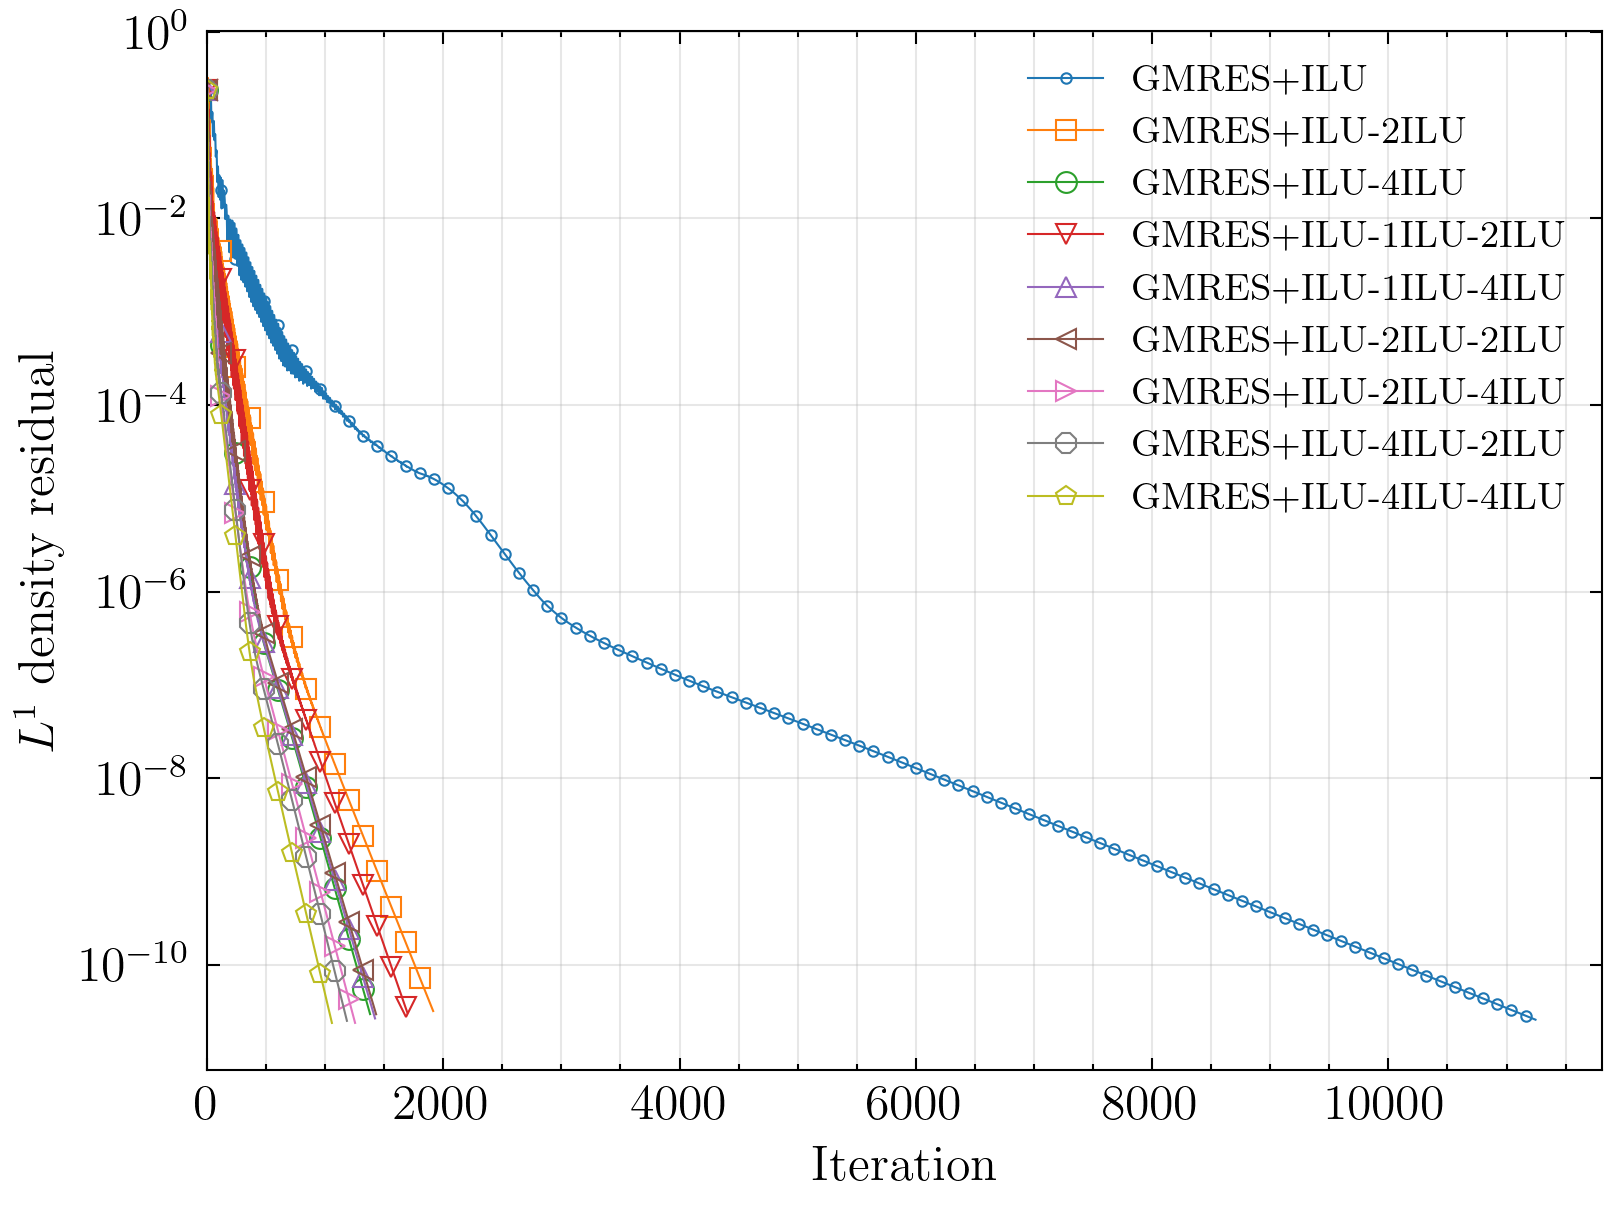

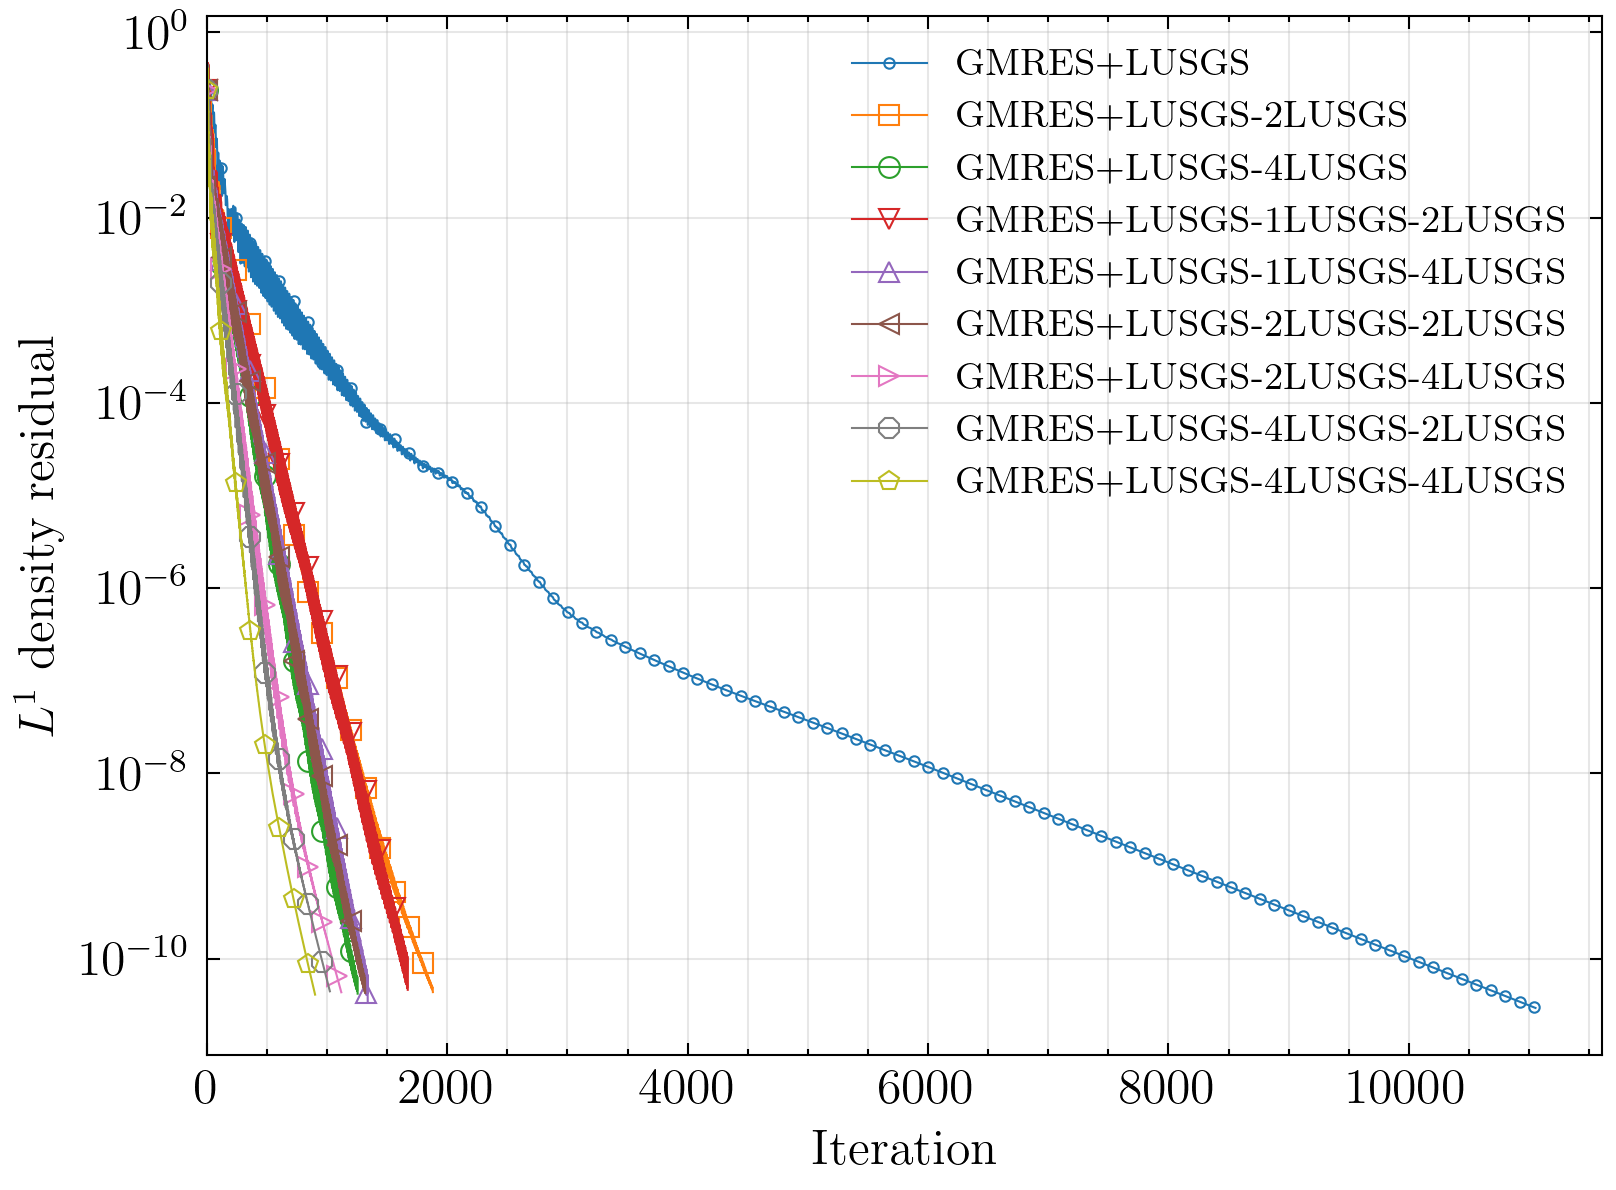

In [46]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1003 + 10000 * ifig, figsize=(6, 4.5), dpi=300)
    plt.clf()

    # plt.title(f"AOA 15, res-time, {subset}")
    iMarker = 0
    for i, (data, name) in enumerate(data_AOA15):
        if name.startswith(head):
            plotOne(data, name_mapper(name), iMarker, xAxis="tWall", yAxis="res0")
            iMarker += 1
    plotAfter(
        (0, tRanges[ifig]), xlabel=r"$t_{wall}$", ylabel=r"$L^1$ density residual"
    )
    plt.savefig(f"{out_name}_rt_{subset}.{format}", format=format)

for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1004 + 10000 * ifig, figsize=(6, 4.5), dpi=300)
    plt.clf()

    iMarker = 0
    for i, (data, name) in enumerate(data_AOA15):
        if name.startswith(head):
            plotOne(data, name_mapper(name), iMarker, xAxis="iter", yAxis="res0")
            iMarker += 1
    plotAfter((0, nRanges[ifig]), xlabel=r"Iteration", ylabel=r"$L^1$ density residual")
    plt.savefig(f"{out_name}_ri_{subset}.{format}", format=format)

/tmp/ipykernel_2607131/880408817.py:171: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


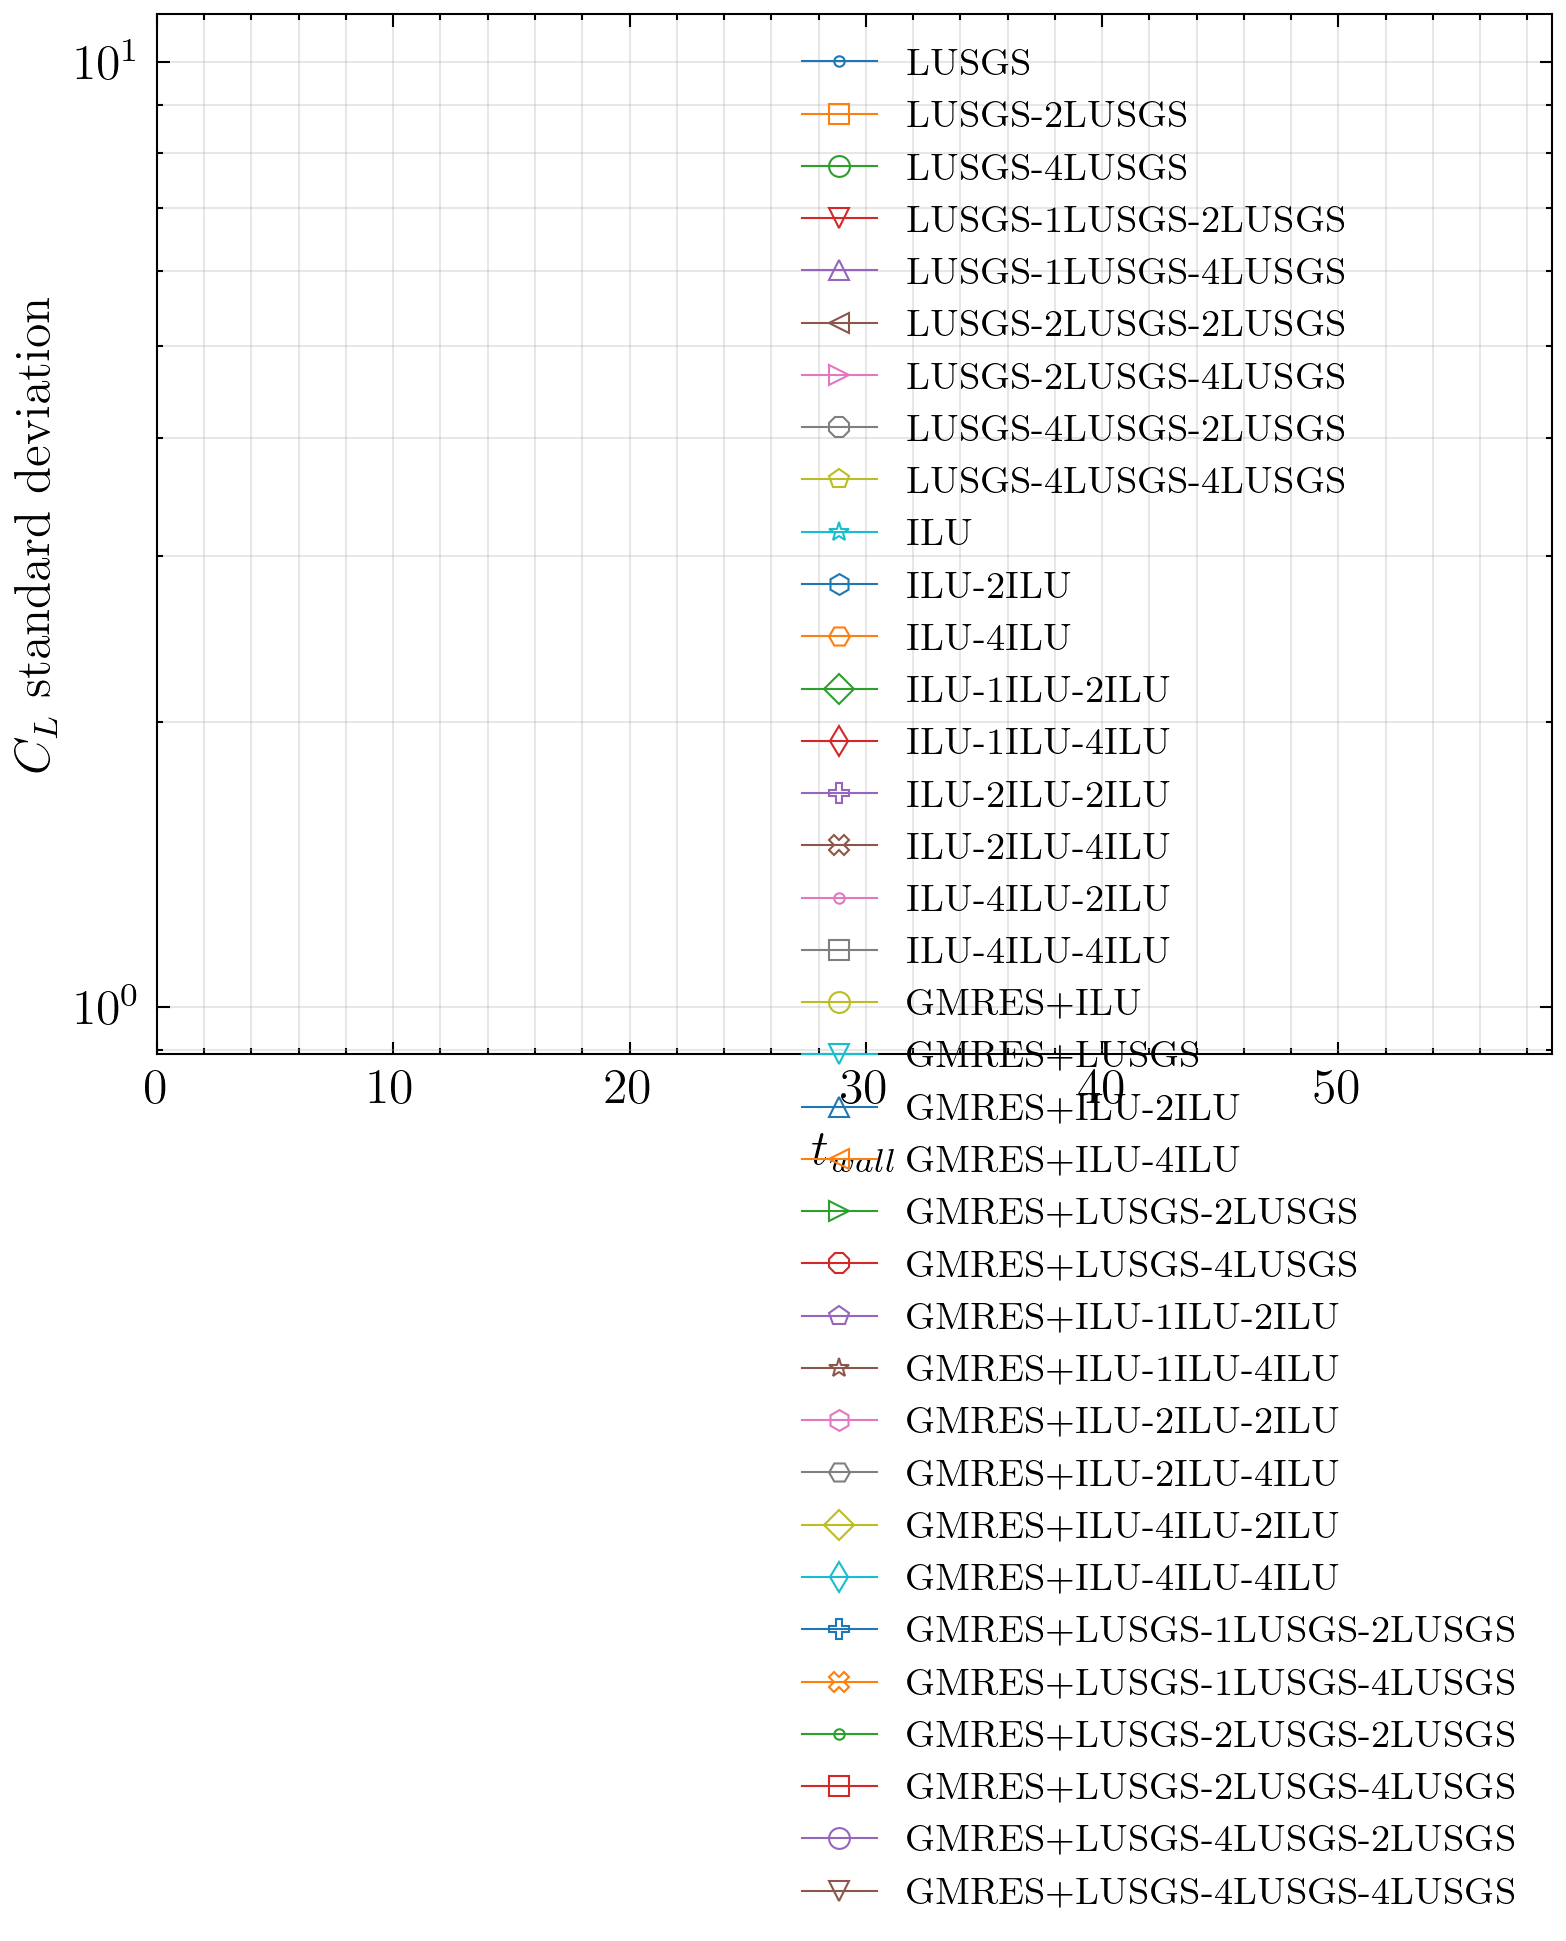

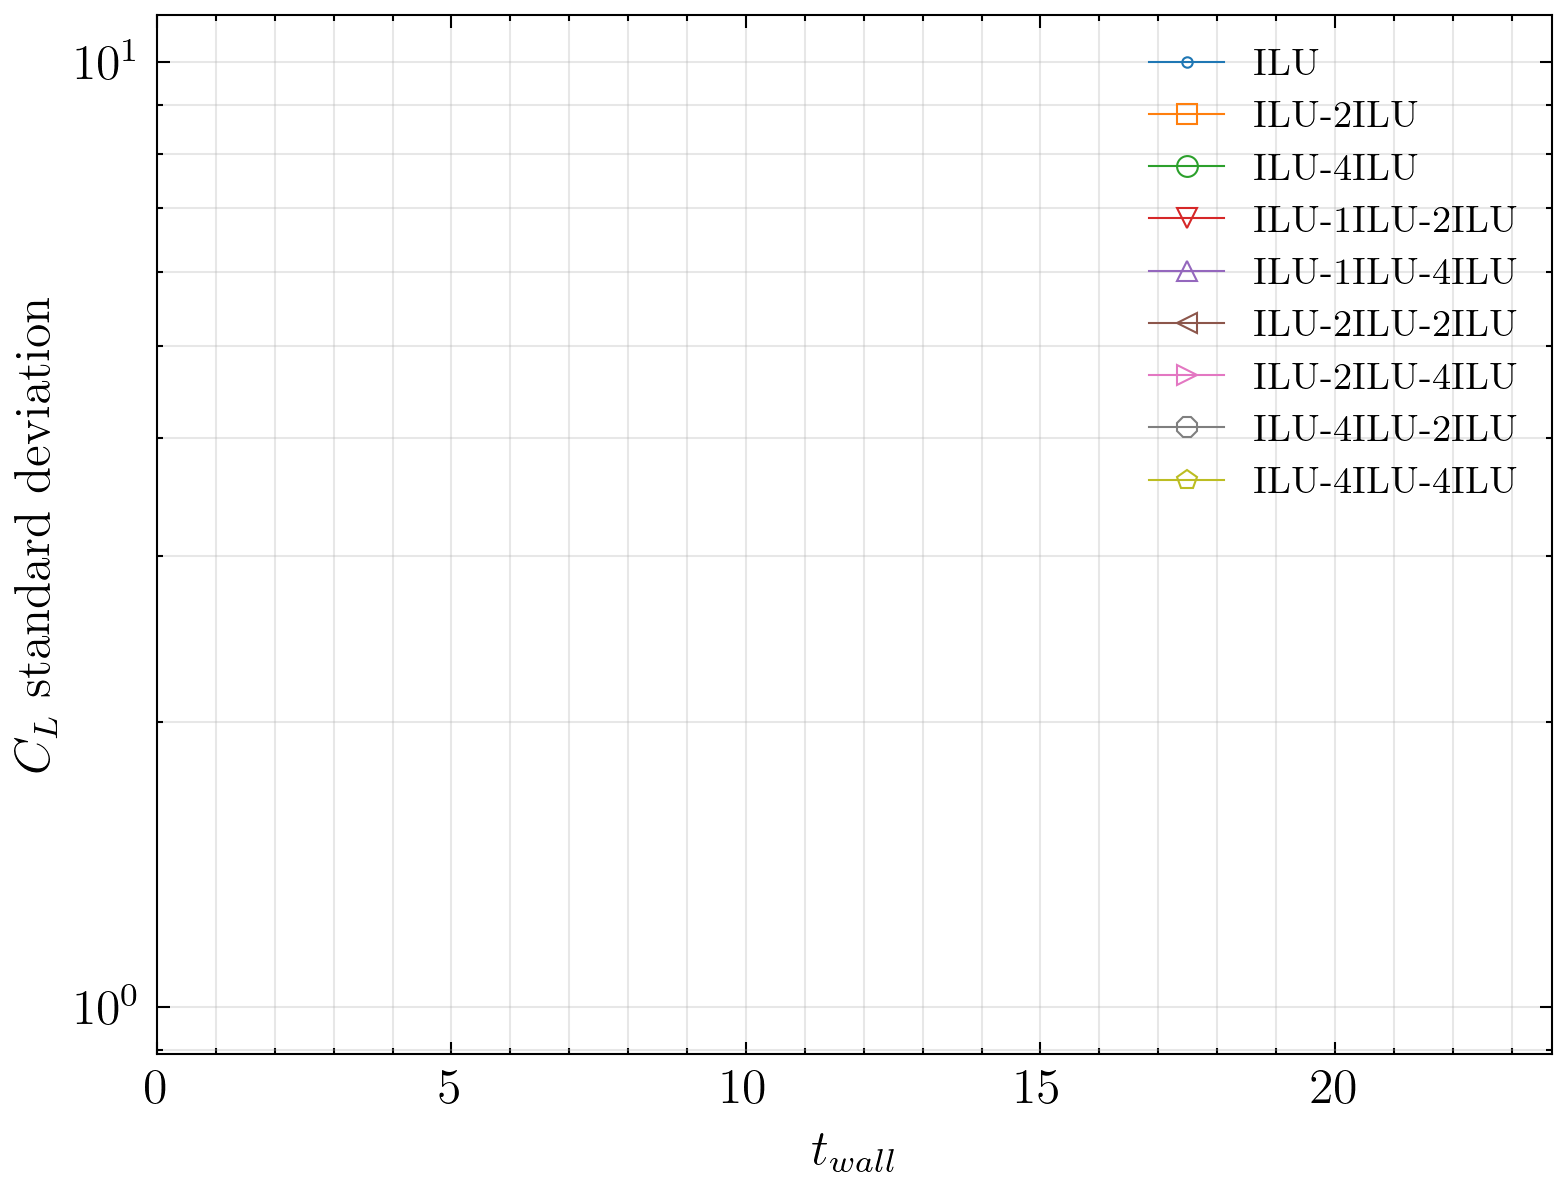

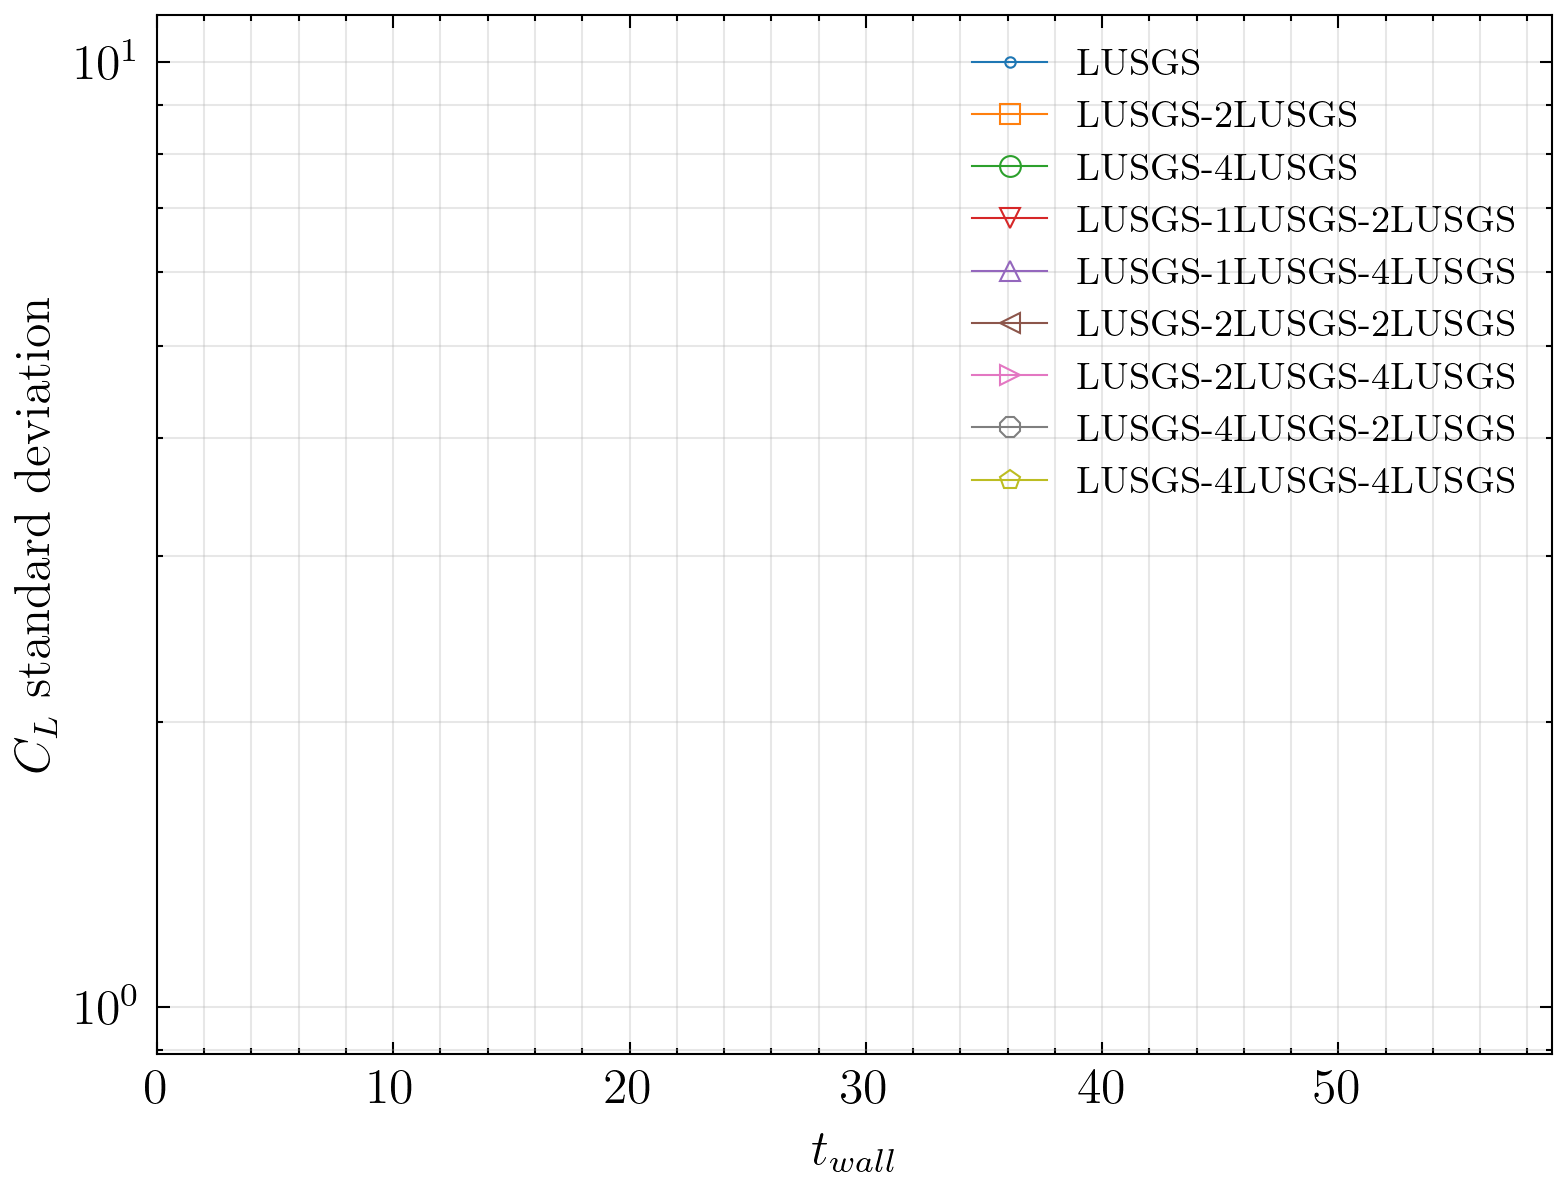

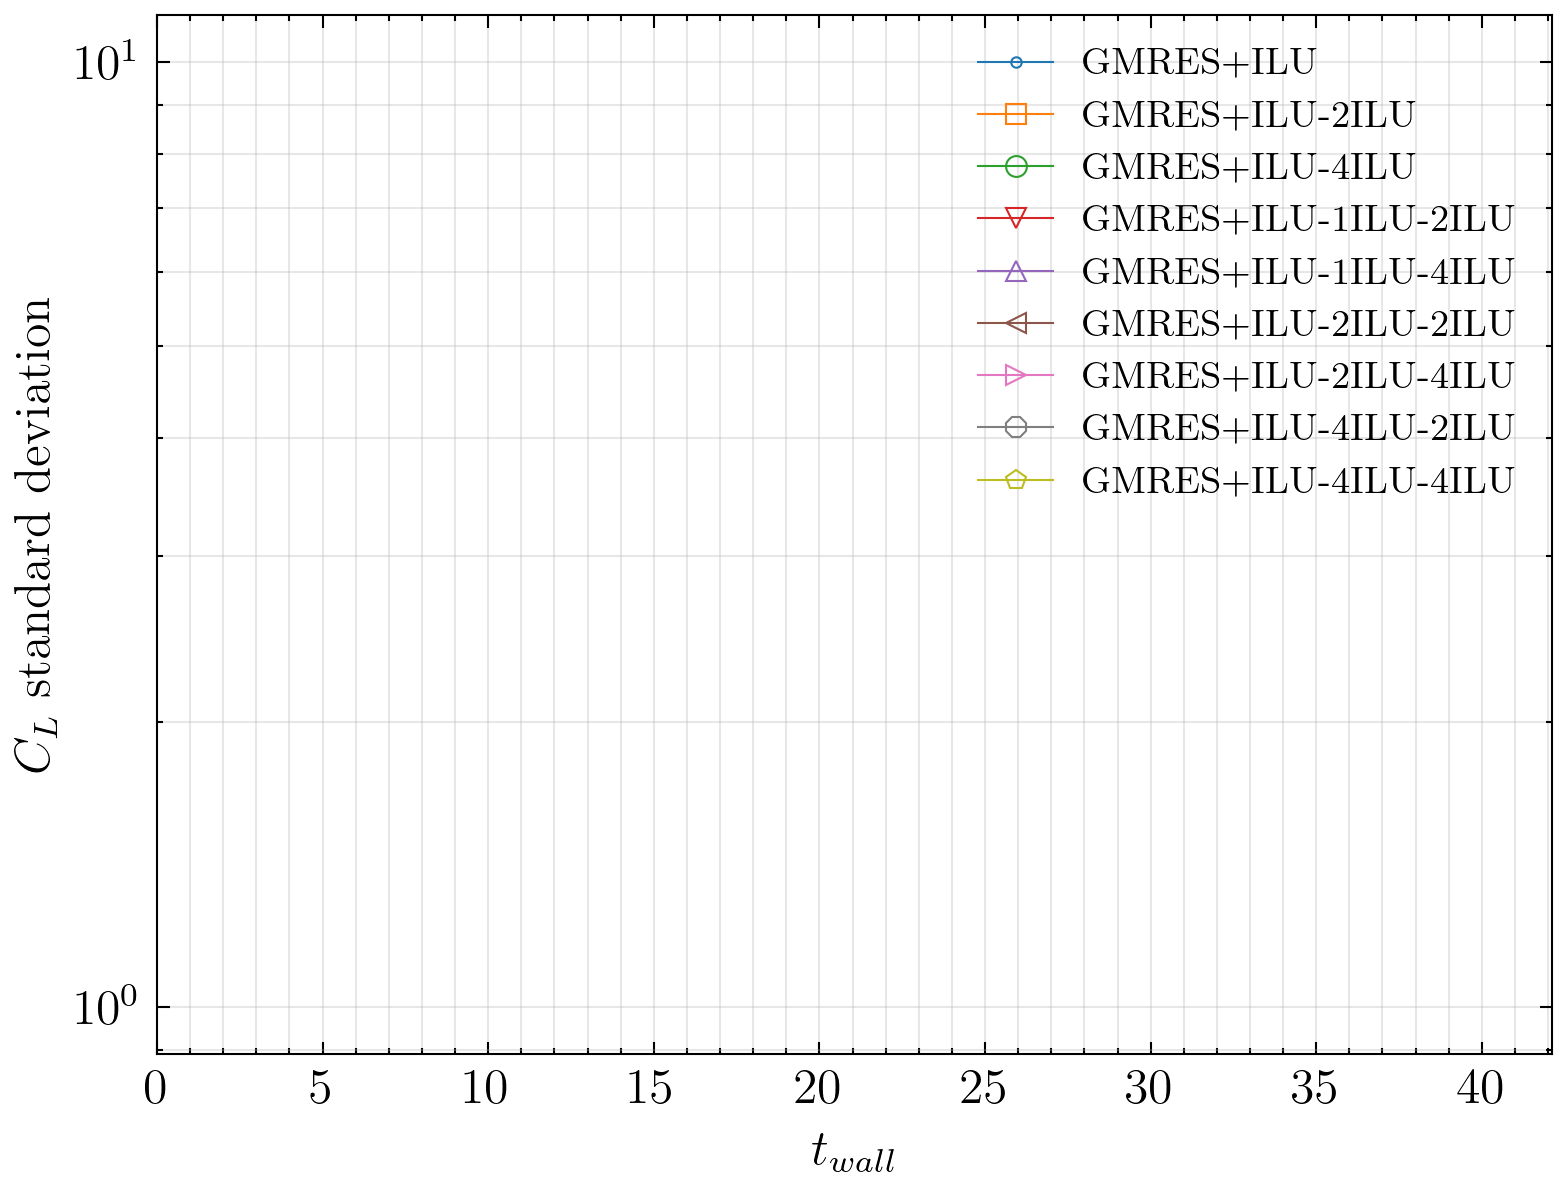

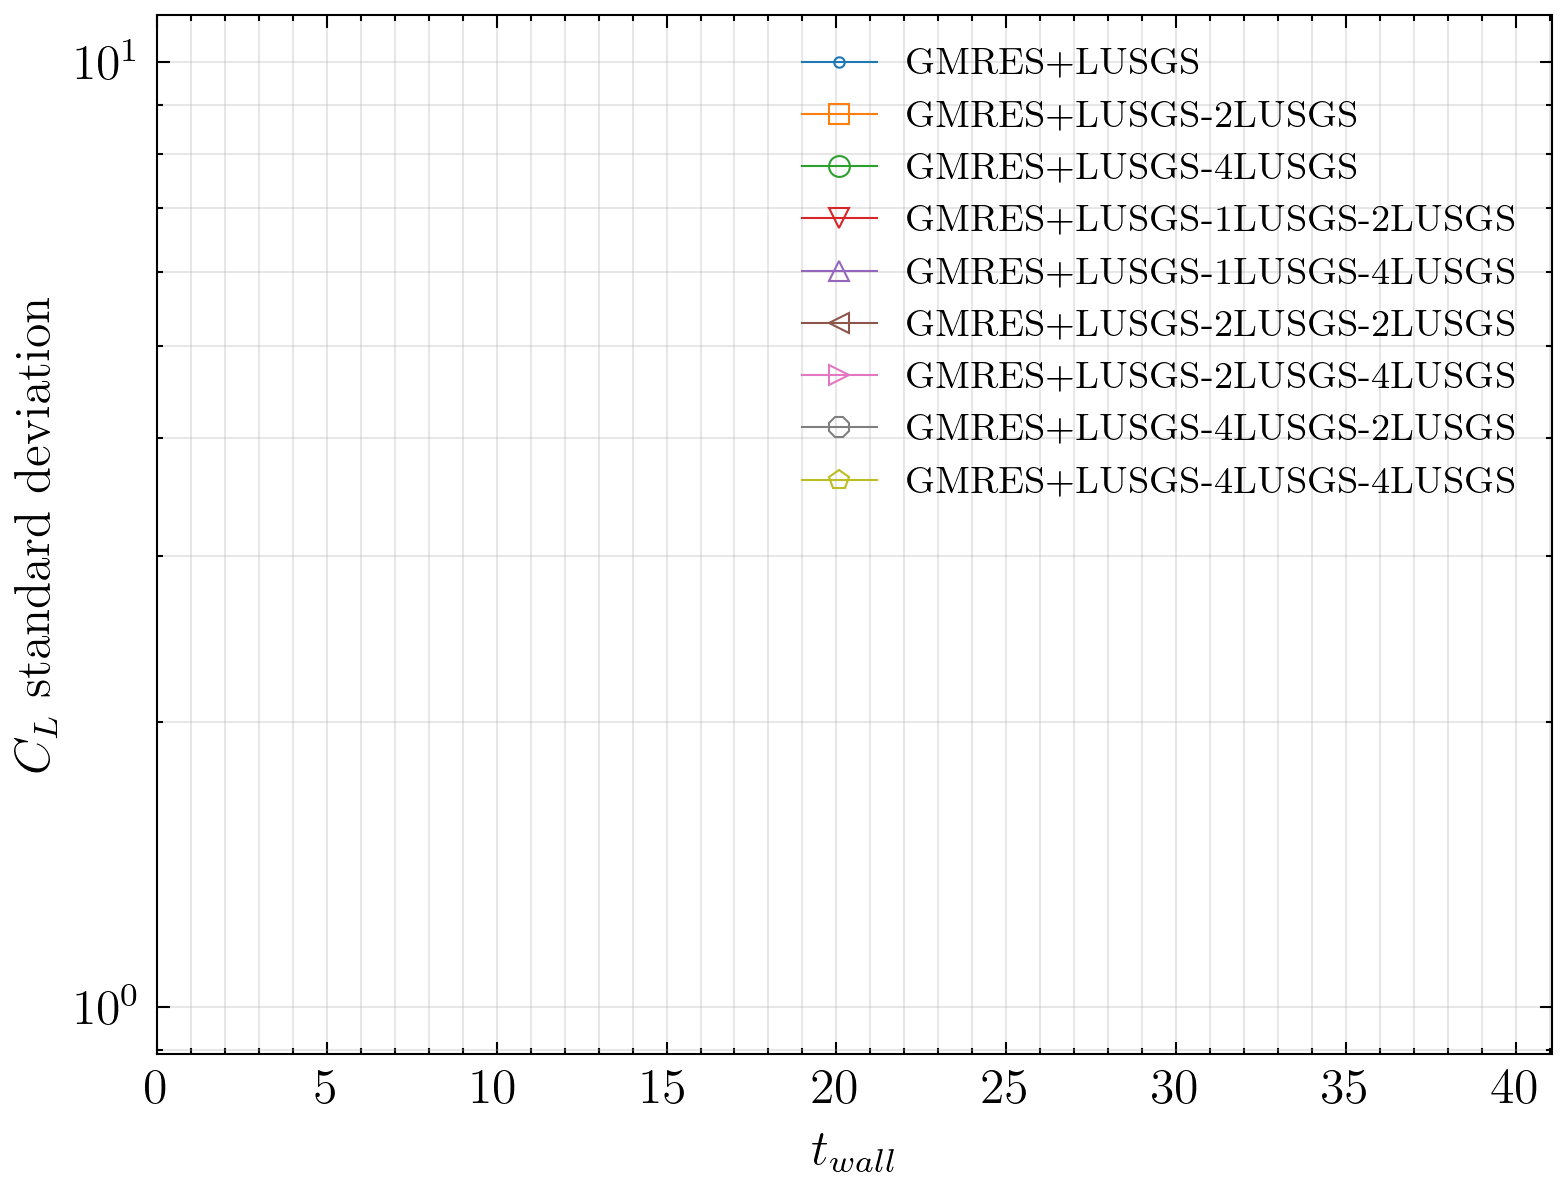

In [47]:
for ifig, subset in enumerate(series):
    if subset == "all":
        head = ""
    else:
        head = subset

    plt.figure(1005 + 10000 * ifig, figsize=(6, 4.5), dpi=300)
    # plt.title(f"AOA 15, CL std-time, {subset}")
    iMarker = 0
    for i, (data, name) in enumerate(data_AOA15):
        if name.startswith(head):
            plotOne(data, name_mapper(name), iMarker, xAxis="tWall", yAxis="CL", std=100)
            iMarker += 1
    plotAfter((0, tRanges[ifig]), xlabel=r"$t_{wall}$", ylabel="$C_L$ standard deviation")
    plt.savefig(f"{out_name}_clstdT_{subset}.{format}", format=format)